# KICKSTARTER DATA CLEANING

This script will clean the python data and perform machine learning techniques.

In [3]:
import os
import sys
import datetime
import json
import re
import string
import math
from datetime import date
import time

import pickle
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
import seaborn as sns
#from ggplot import *

from tableausdk import *
from tableausdk.HyperExtract import *

from scipy import stats
#%matplotlib inline
sns.set()

# CLEANING PROCESS

The cleaning process will consist of the following phases:

1. Initial set-up and Loading.
2. Data overview.
3. Data cleaning.
    1. Missing Values.
    2. Columns re-format.

## 1. Initial Set-up and Data Loading

In [4]:
def initial_setup():
    """Create Initial setup of directories variables, and dataframe vars to use.
    Returns:
        A tuple containing:
            - datadir....Absolute Path to the data directory of the project.
            - dirname....Absolute Path of directory that contains this file.
            - imagesdir..Absolute path of directory that contains the images.
            - colnames...A list containing the initial colnames of the dataframe.
    """
    dirname = os.path.dirname(os.path.abspath('__file__'))
    datadir =  os.path.join(
                os.path.abspath(os.path.join(os.path.join(dirname, os.pardir), os.pardir)), 
                'data'
            )
    imagesdir =  os.path.join(os.path.abspath(os.path.join(dirname, os.pardir)), 'images')
    initial_colnames = sorted(
                ['backers_count', 'blurb', 'category', 'country', 'created_at', 'currency',
                 'deadline', 'goal', 'id', 'launched_at', 'location', 'pledged', 'slug',
                 'spotlight', 'staff_pick', 'state', 'static_usd_rate', 'usd_pledged']
            )
    return dirname, datadir, imagesdir, initial_colnames


def read_from_disk(filename):
    """Read a dataframe from a filename in disk.
    Args:
        filename....Path to the file.
    Returns:
        A pandas dataframe.
    """
    return pickle.load(open(filename, 'rb'))


def store_dataframe(dataframe, filename):
    """Store the dataframe using pickle.
    Args:
        dataframe...pandas dataframe to store.
        filename....Path to the file to store the datafram in.
    Returns:
        Nothing.
    """
    pickle.dump(dataframe, open(filename, 'wb'))

In [5]:
# 0 - Initial directories and colnames set up
print("Step 0: Initial directories and colnames set up")
dirname, datadir, imagesdir, initial_colnames = initial_setup()
print("Directory of this file is {}".format(dirname))
print("Data directory is {}".format(datadir))
print("Images directory is {}".format(imagesdir))
print("Initial columns for our model are: \n{}".format(initial_colnames))

Step 0: Initial directories and colnames set up
Directory of this file is /home/agericke/crowdfunding_ml/src/formatting
Data directory is /home/agericke/crowdfunding_ml/data
Images directory is /home/agericke/crowdfunding_ml/src/images
Initial columns for our model are: 
['backers_count', 'blurb', 'category', 'country', 'created_at', 'currency', 'deadline', 'goal', 'id', 'launched_at', 'location', 'pledged', 'slug', 'spotlight', 'staff_pick', 'state', 'static_usd_rate', 'usd_pledged']


In [6]:
# 1 - Load from disk the complete Merged Dataframe.
print("\n\n\nStep 1: Load from disk the complete Merged Dataframe.")
filename = os.path.join(datadir, 'dataframe_total.pkl')
print("Completed Dataframe read from file {}".format(filename))
data = read_from_disk(filename)
# Print summary of dataframe
print(
    "Dataframe contains {} projects and {} columns for each project\n".format(
        data.shape[0],
        data.shape[1]
        )
)




Step 1: Load from disk the complete Merged Dataframe.
Completed Dataframe read from file /home/agericke/crowdfunding_ml/data/dataframe_total.pkl
Dataframe contains 344209 projects and 18 columns for each project



## 2. Data Overview.

In [7]:
# 2 - Take a look at the data, data types and data info.
print(data.head(5))
print(data.describe())
print(data.info())
print(data.get_dtype_counts())

      backers_count                                              blurb  \
2967              1  To create art, an artist must have their tools...   
4106              0  Firestarter kits for revolutionaries! markers,...   
635               3  Sophie is an aspiring artist! She will be 5 in...   
138            4870  Every spinning top â is built on the same be...   
1456              0  Watch your children as they open this giant su...   

                                               category country  created_at  \
2967  {"urls":{"web":{"discover":"http://www.kicksta...      US  1428557824   
4106  {"urls":{"web":{"discover":"http://www.kicksta...      US  1453437274   
635   {"urls":{"web":{"discover":"http://www.kicksta...      US  1409805071   
138   {"urls":{"web":{"discover":"http://www.kicksta...      CA  1448217795   
1456  {"urls":{"web":{"discover":"http://www.kicksta...      GB  1452957332   

     currency    deadline     goal          id  launched_at  \
2967      USD  14

## 3. DATA CLEANING

### 3.1. Missing Values

In [8]:
def remove_cols(dataframe, cols_to_remove):
    """Remove all the columns specified by the list from dataframe.
    Args:
        cols_to_remove....List of columns we want to remove
        dataframe.........The dataframe to remove the columns from.
    Returns:
        A dataframe with only the columns we want.
    """
    dataframe.drop(cols_to_remove, inplace=True, axis=1)
    print("Succesfully removed columns {}".format(cols_to_remove))
    return dataframe


def categorical_with_per_count(dataframe, feature):
    """Calculate frequency of the categorical feature with % and count base.
    Sorted on the descending order.

    Params:
        dataframe.....Pandas dataframe from where to pick the data.
        feature.......Column for which we want to calculate the data for.
    """
    freq_merged = pd.concat([dataframe[feature].value_counts(normalize=True) * 100,
                             dataframe[feature].value_counts(normalize=False)], axis=1)
    freq_merged.columns = [feature + '_%', feature + '_count']
    return freq_merged


def check_missing_values_and_drop(data, drop=False):
    """Check the number of missing values that we have.
    Args:
        data....Dataframe to check the missing values.
        drop....Boolean to indicate if we want to drop missing values or not.
    Returns:
        Prints a summary of the number and % of missing values.
        Returns the dataframe with no missing values.
    """
    total_rows = data.shape[0]
    # isna() sets True NA values and numpy.NaN. Empty strings or infinites are not set as True.
    na_col_counts = data.isna().sum().sort_values(ascending = False)
    freq_merged = pd.concat([na_col_counts, (na_col_counts/total_rows)*100], axis=1)
    freq_merged.columns = ['Total_count', '%_count']

    if drop:
        data = data.dropna()
    
    return data, freq_merged
    # TODO: See if we can check the missing indexes for each column and run a study on them.
    # TODO: Run experiments to try to identify is the missing values are mainly because of a reason 
    #    or one type of project, or specific to one period of time (see if they are missing at 
    #    random, missing not at random...)

In [9]:
# 3 - Look for missing values for every row and print summary.
print("\n\n\nStep 2: Look for missing values for every row and print summary.")
data, na_freq = check_missing_values_and_drop(data, drop=False)
print("We have a total of {} rows with missing data, which correspond to {:.2f}% missing rows.".format(
        int(na_freq.sum()[0]), na_freq.sum()[1])
)
print('\nColumns with at least one missing value are:')
print('{}'.format(na_freq[na_freq.Total_count > 0]))




Step 2: Look for missing values for every row and print summary.
We have a total of 1090 rows with missing data, which correspond to 0.32% missing rows.

Columns with at least one missing value are:
          Total_count   %_count
location         1072  0.311439
blurb              18  0.005229


Lets take a look at missing values per country.

In [10]:
df_null = data[data.isna().any(axis=1)]
df_null.country.value_counts().sort_values(ascending = False)
print('\nTaking a look at missing values per countries we find:')
print('{:-<15}{:->15}'.format('Country', 'Nº NA Values'))
[print('{:<15}{:>15}'.format(row[0], row[1])) for row in df_null.country.value_counts().sort_values(ascending = False).items()]


Taking a look at missing values per countries we find:
Country-----------Nº NA Values
US                        1087
GB                           1
AU                           1
DE                           1


[None, None, None, None]

We drop NA Values

In [11]:
# We drop NA values
data, na_freq = check_missing_values_and_drop(data, True)
del df_null

###  3.2 Re-format Columns.

#### A. First of all we will rename the objective column to result.

In [12]:
# 4-1 Change state column to result
data['result'] = data['state']
data.drop('state', inplace=True, axis=1)

#### B. Then we will re factor currency related columns.

In [13]:
# 4-2 Re-factor money related columns
data['goal_usd'] = data['goal']*data['static_usd_rate']
# Create pledged_usd
data['pledged_usd'] = data['pledged']*data['static_usd_rate']

In [14]:
# Study differences from calculated to the value we had.
print(abs(data['usd_pledged'] - data['pledged_usd']).describe())
# Remove not any more useful cols.
data = remove_cols(data, ['goal', 'pledged', 'static_usd_rate', 'usd_pledged'])

count    3.431190e+05
mean     1.684488e-13
std      3.711379e-12
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.313226e-10
dtype: float64
Succesfully removed columns ['goal', 'pledged', 'static_usd_rate', 'usd_pledged']


#### C. Change type of date columns to datetime.

In [15]:
# 4-3 Create date type variables for created_at, launched_at and deadline
data['launched_at'] = pd.to_datetime(data['launched_at'], unit='s')
data['deadline'] = pd.to_datetime(data['deadline'], unit='s')
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')

#### D. Create category and subcategory columns.

In [16]:
def obtain_cat_and_subcat_for_row(row):
    """Obtain category and subcategory of a row. notice that if subcategory not present,
    this will set it to none.
    Args:
        row....The dataframe row.
    Returns:
        A tuple containing:
            - category: Value for obtained category.
            - subcategory: Value for obtained subcategory, and None if not present.
    """
    # Convert string to dict
    cat_split = json.loads(row['category'])['slug'].split('/')
    # Save category and subcategory
    category = cat_split[0]
    subcategory = ""
    
    if len(cat_split)>1:
        # There is a sucategory
        subcategory = cat_split[1]
    
    return (category, subcategory)
    

def create_cat_and_subcat(data):
    """Save in a new column the category and subcategory extracted from the category column.
    Args:
        data.....Dataframe.
    Returns:
        A dataframe with category and subcategory vars created.¡ for each row.
    """
    cat_subcat = data.apply(obtain_cat_and_subcat_for_row, axis=1)
    data['main_category'] = [c[0].lower().strip().replace(' ','-') for c in cat_subcat]
    data['sub_category'] = [c[1].lower().strip().replace(' ','-') for c in cat_subcat]
    data.drop('category', inplace=True, axis=1)
    print('Succesfully created columns category and subcategory')
    
    return data

In [17]:
# 4-4 Create category and sub-category columns
data = create_cat_and_subcat(data)

Succesfully created columns category and subcategory


#### E. Extract Location values from json column.

In [18]:
def obtain_location_vars_for_row(row):
    """Obtain country, state and city.
    Args:
        row....The dataframe row.
    Returns:
        A tuple containing:
            - country: Country oobtained.
            - state: State obtained.
            - loc_type: Type of location obtained.
    """
    # Convert string to dict
    loc_dict = json.loads(row['location'])
    country = loc_dict['country']
    state = loc_dict['state']
    city =  loc_dict['name']
    
    return (country, state, city)
    

def create_location_vars(data):
    """Save in a new column the country, state and location type extracted from the location column.
    Args:
        data.....Dataframe.
    Returns:
        A dataframe with country, state and location vars created for each row.
    """
    location_vars = data.apply(obtain_location_vars_for_row, axis=1)
    data['country2'] = [c[0] for c in location_vars]
    data['state'] = [c[1] for c in location_vars]
    data['city'] = [c[2] for c in location_vars]
    data.drop("location", inplace=True, axis=1)
    print("Succesfully created columns country, region_state and type")
    
    return data

In [19]:
# 4-5 Create location columns.
data = create_location_vars(data)
data[data.country != data.country2]
# After some comparison we determine that country2 is more realiable than country.
data['country'] = data['country2']
data.drop('country2', inplace=True, axis=1)

Succesfully created columns country, region_state and type


#### F. Check Missing values for newly created columns. 

In [20]:
# 4-6 Check missing data on new columns.
data, na_freq = check_missing_values_and_drop(data, False)
print("As we can see, we have very low percentage of missing values, with a total of {} rows\
that correspond to {:.2f}%".format(int(na_freq.sum()[0]), na_freq.sum()[1]))
print('\nThe columns with at least one missing value are:')
print('{}'.format(na_freq[na_freq.Total_count > 0]))

As we can see, we have very low percentage of missing values, with a total of 96 rowsthat correspond to 0.03%

The columns with at least one missing value are:
       Total_count   %_count
state           96  0.027979


We see that only state column has missing values. Although we could easily drop those values we will perform an analysis just for educational purposes.

In [21]:
# Lets study where does missing values come from.
df_null = data[data.isna().any(axis=1)]
unique_na_cities = np.sort(df_null.city.unique())
unique_na_countries = np.sort(df_null.country.unique())
print("Cities that have states with missing values are:")
print(unique_na_cities)
print("\nCountry codes that have state with missing values are:")
print(unique_na_countries)

Cities that have states with missing values are:
['Adamstown' 'Antarctica' 'Australie' 'Bairiki' 'Dannevirke' 'Gibraltar'
 'Macau' 'Oamaru Central' 'Oranjestad' 'Philipsburg' 'Pristina' 'Rotorua'
 'Rotorua Central' 'Rotorua West' 'Skopje' 'South Oamaru' 'Stratford'
 'Sucker Garden' 'Taihape' 'Taupo' 'Vatican City' 'West Island'
 'Whanganui' 'Willemstad']

Country codes that have state with missing values are:
['AQ' 'AW' 'CC' 'CW' 'GI' 'KI' 'MK' 'MO' 'NZ' 'PN' 'SX' 'VA' 'XK']


We see that these are countries with very small values. These countries may not contain states. We search on Internet the states to which the correspondent cities belong to and will assign them through a dictionary.

In [22]:
# We see that they correspond to very small countries that may not contain states.
country_to_name = {'AQ': 'Antarctica', 'AW': 'Aruba', 'CC': 'Cocos Islands', 'CW': 'Curacao',
                   'GI': 'Gibraltar', 'KI': 'Kiribati', 'MK': 'Macedonia', 'MO': 'Macau',
                   'NZ': 'New Zealand', 'PN': 'Pitcairn', 'SX': 'Sint Maarten', 'VA': 'Vatican',
                   'XK': 'Kosovo'}   
[print("\n", data[data['country'] == country][['country', 'state', 'city']]) for country in unique_na_countries]


      country state        city
886       AQ  None  Antarctica
976       AQ  None  Antarctica
2923      AQ  None  Antarctica
2127      AQ  None  Antarctica
1224      AQ  None  Antarctica
1442      AQ  None  Antarctica
1902      AQ  None  Antarctica
3623      AQ  None  Antarctica
2040      AQ  None  Antarctica
13        AQ  None  Antarctica
439       AQ  None  Antarctica
3450      AQ  None  Antarctica
3433      AQ  None  Antarctica
375       AQ  None  Antarctica
3020      AQ  None  Antarctica
1516      AQ  None  Antarctica
134       AQ  None  Antarctica
1997      AQ  None  Antarctica
456       AQ  None  Antarctica
1179      AQ  None  Antarctica
1802      AQ  None  Antarctica
2796      AQ  None  Antarctica
1450      AQ  None  Antarctica
2015      AQ  None  Antarctica
1094      AQ  None  Antarctica
402       AQ  None  Antarctica

      country state        city
1809      AW  None  Oranjestad

      country state         city
1731      CC  None  West Island

      country state        cit

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [23]:
city_to_state = {'MK': {'Skopje': 'Skopje'}, 'NZ': {'Taupo': 'Waikato', 'Rotorua Central': 'Bay of Plenty', 
                 'Dannevirke': 'Manawatu Wanganui', 'Rotorua West': 'Bay of Plenty',
                 'Whanganui': 'Manawatu Wanganui', 'Taihape': 'Manawatu Wanganui', 
                 'Rotorua': 'Bay of Plenty', 'Oamaru Central': 'Otago', 'Stratford': 'Taranaki',
                 'South Oamaru': 'Otago'}}
country_to_state = {'AQ': 'Antarctica', 'AW': 'Aruba', 'CC': 'Cocos Islands', 'CW': 'Curacao',
                   'GI': 'Gibraltar', 'KI': 'Kiribati', 'MO': 'Macau', 'PN': 'Pitcairn',
                   'SX': 'Sint Maarten', 'VA': 'Vatican', 'XK': 'Kosovo'}

for country in country_to_name.keys():
    if country in country_to_state.keys():
        data.loc[data[data['country'] == country].index, 'state'] = country_to_state[country]
    else:
        cities = city_to_state[country]
        for city in cities.keys():
            data.loc[data[(data['country'] == country) & (data['city'] == city)].index, 'state'] = cities[city]
            
data, na_freq = check_missing_values_and_drop(data, False)
print('The columns with at least one missing value are:')
print('{}'.format(na_freq[na_freq.Total_count > 0]))

del na_freq, df_null, unique_na_cities, unique_na_countries, city_to_state, country_to_state

The columns with at least one missing value are:
Empty DataFrame
Columns: [Total_count, %_count]
Index: []


In [24]:
# You cannot delete or append to a .tde file if it is opened in Tableau
def to_tde(dataframe, filename, tb_name='Kickstarter'):
    """Function for creating an hyper dataset for Tableua from the pandas dataframe.
    Args:
        - dataframe.....Pandas dataframe to create the extract from.
        - filename......Path to the file where we will store the .hyper extract.
        - tb_name.......Name of the table to be created. (Deafault: Kickstarter)
        
    Returns:
        Nothing
    """    
    # 0 - Initialize extract API
    ExtractAPI.initialize()

    # Step 1: Create the Extract File
    dataExtract = Extract(filename)

    if dataExtract.hasTable(tb_name):
        return print("tde already exist use another name")

    # Step 2: Create the table definition
    if (not dataExtract.hasTable(tb_name)):
        dataSchema = TableDefinition()
        dataSchema.addColumn('backers_count', Type.INTEGER)
        dataSchema.addColumn('blurb', Type.UNICODE_STRING)
        dataSchema.addColumn('category', Type.CHAR_STRING)
        dataSchema.addColumn('country', Type.CHAR_STRING)
        dataSchema.addColumn('created_at', Type.DATETIME)
        dataSchema.addColumn('currency', Type.CHAR_STRING)
        dataSchema.addColumn('deadline', Type.DATETIME)
        dataSchema.addColumn('id', Type.INTEGER)
        dataSchema.addColumn('launched_at', Type.DATETIME)
        dataSchema.addColumn('location', Type.UNICODE_STRING)
        dataSchema.addColumn('slug', Type.UNICODE_STRING)
        dataSchema.addColumn('spotlight', Type.BOOLEAN)
        dataSchema.addColumn('staff_pick', Type.BOOLEAN)
        dataSchema.addColumn('state', Type.CHAR_STRING)
        dataSchema.addColumn('goal_usd', Type.DOUBLE)
        dataSchema.addColumn('pledged_usd', Type.DOUBLE)

        # Step 3: Create a table in the image of the table definition
        table = dataExtract.addTable(tb_name, dataSchema)

    # Step 4: Create rows and insert them one by one
    newRow = Row(dataSchema)
    for i in range(0, len(dataframe)):
        newRow.setInteger(0, dataframe['backers_count'].iloc[i])
        newRow.setString(1, dataframe['blurb'].iloc[i])
        newRow.setCharString(2, dataframe['category'].iloc[i])
        newRow.setCharString(3, dataframe['country'].iloc[i])
        newRow.setDateTime(
                4,
                dataframe['created_at'].iloc[i].year,
                dataframe['created_at'].iloc[i].month,
                dataframe['created_at'].iloc[i].day,
                dataframe['created_at'].iloc[i].hour,
                dataframe['created_at'].iloc[i].minute,
                dataframe['created_at'].iloc[i].second,
                dataframe['created_at'].iloc[i].microsecond
            )
        newRow.setCharString(5, dataframe['currency'].iloc[i])
        newRow.setDateTime(
                6,
                dataframe['deadline'].iloc[i].year,
                dataframe['deadline'].iloc[i].month,
                dataframe['deadline'].iloc[i].day,
                dataframe['deadline'].iloc[i].hour,
                dataframe['deadline'].iloc[i].minute,
                dataframe['deadline'].iloc[i].second,
                dataframe['deadline'].iloc[i].microsecond
            )
        newRow.setInteger(7, dataframe['id'].iloc[i])
        newRow.setDateTime(
                8,
                dataframe['launched_at'].iloc[i].year,
                dataframe['launched_at'].iloc[i].month,
                dataframe['launched_at'].iloc[i].day,
                dataframe['launched_at'].iloc[i].hour,
                dataframe['launched_at'].iloc[i].minute,
                dataframe['launched_at'].iloc[i].second,
                dataframe['launched_at'].iloc[i].microsecond
            )
        newRow.setString(9, dataframe['location'].iloc[i])
        newRow.setString(10, dataframe['slug'].iloc[i])
        newRow.setBoolean(11, dataframe['spotlight'].iloc[i])
        newRow.setBoolean(12, dataframe['staff_pick'].iloc[i])
        newRow.setCharString(13, dataframe['state'].iloc[i])
        newRow.setDouble(14, dataframe['goal_usd'].iloc[i])
        newRow.setDouble(15, dataframe['pledged_usd'].iloc[i])
        
        table.insert(newRow)

    # Step 5: Close the tde
    dataExtract.close()
    
    # Step 6: Close the Tableau Extract API
    ExtractAPI.cleanup()

## 4. Exploratory Data Analysis

### 4.1. Overview of the Data

In [25]:
# 5-1 Overview of the data
data.info()
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343119 entries, 2967 to 3281
Data columns (total 18 columns):
backers_count    343119 non-null int64
blurb            343119 non-null object
country          343119 non-null object
created_at       343119 non-null datetime64[ns]
currency         343119 non-null object
deadline         343119 non-null datetime64[ns]
id               343119 non-null int64
launched_at      343119 non-null datetime64[ns]
slug             343119 non-null object
spotlight        343119 non-null bool
staff_pick       343119 non-null bool
result           343119 non-null object
goal_usd         343119 non-null float64
pledged_usd      343119 non-null float64
main_category    343119 non-null object
sub_category     343119 non-null object
state            343119 non-null object
city             343119 non-null object
dtypes: bool(2), datetime64[ns](3), float64(2), int64(2), object(9)
memory usage: 55.2+ MB


,backers_count,blurb,country,created_at,currency,deadline,id,launched_at,slug,spotlight,staff_pick,result,goal_usd,pledged_usd,main_category,sub_category,state,city
count,343119.000000,343119,343119,343119,343119,343119,3.431190e+05,343119,343119,343119,343119,343119,3.431190e+05,3.431190e+05,343119,343119,343119,343119
unique,NaN,339413,213,342851,14,316408,NaN,342679,343119,2,2,5,NaN,NaN,15,146,1377,17197
top,NaN,Help support the largest creative collaboratio...,US,2012-10-13 22:25:09,USD,2018-07-04 03:59:00,NaN,2018-02-01 22:34:51,the-human-project-funding-the-mixing-mastering...,False,False,successful,NaN,NaN,film-&-video,,CA,Los Angeles
freq,NaN,52,242205,2,250298,55,NaN,3,1,187729,306537,155390,NaN,NaN,46872,35220,44879,16326
first,NaN,NaN,NaN,2009-04-22 02:11:10,NaN,2009-05-15 23:10:00,NaN,2009-04-28 11:55:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-12-12 02:42:36,NaN,2020-02-10 04:37:15,NaN,2019-12-12 05:10:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,143.018810,NaN,NaN,NaN,NaN,NaN,1.074305e+09,NaN,NaN,NaN,NaN,NaN,3.846280e+04,1.237205e+04,NaN,NaN,NaN,NaN
std,1042.659654,NaN,NaN,NaN,NaN,NaN,6.192763e+08,NaN,NaN,NaN,NaN,NaN,1.000317e+06,1.093359e+05,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,8.624000e+03,NaN,NaN,NaN,NaN,NaN,1.000000e-02,0.000000e+00,NaN,NaN,NaN,NaN
25%,3.000000,NaN,NaN,NaN,NaN,NaN,5.370726e+08,NaN,NaN,NaN,NaN,NaN,1.848669e+03,5.800000e+01,NaN,NaN,NaN,NaN


### 4.2. Check Valid Key

In [26]:
# 5-2 Check valid key
print((data.id.value_counts() > 1).sum())
data.set_index('id', inplace=True)

0


###  4.3 Per Variable Study

####  A. Objective variable - result

In [27]:
# 5-4.1 Objective variable.
print(data['result'].value_counts().sort_values(ascending=False))
print('We see that we have a total of 5 different project results')
print('Successful and failed projects account for {:.2f}% of all projects of the dataset'.format(
        data['result'].value_counts(normalize=True).loc[['successful', 'failed']].sum()*100
        )
)

successful    155390
failed        133428
live           36067
canceled       17156
suspended       1078
Name: result, dtype: int64
We see that we have a total of 5 different project results
Successful and failed projects account for 84.17% of all projects of the dataset


In [28]:
def plot(plot_data, filename, colors=None, title=None, stacked=False, kind='bar', figsize=None,
         y_format=None, x_format=None, x_label=None, y_label=None, x_rot=0):
    """Bar plot with specific parameters and values.
    Args:
        - plot_data.......Pandas data to be plotted.
        - filename........Absolute filename path to store plot.
        - title...........Title for the plot.
        - stacked.........Whether to plot stack values (only relevant for bar kind plots).
        - kind............Type of plot (default= bar).
        - figsize.........Tuple indicating figure size.
        - y_format........Format for Y Tick Labels.
        - x_format........Format for X Tick Labels.
        - x_label.........X axis label.
        - y_label.........Y axis label.
        - x_rot...........X ticks rotation angle.
    """
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    
    if colors != None:
        if stacked:
            plot_data.plot(kind=kind, ax=ax, color=colors, stacked=stacked)
        else:
            plot_data.plot(kind=kind, ax=ax, color=colors)
    else:
        if stacked:
            plot_data.plot(kind=kind, ax=ax, stacked=stacked)
        else:
            plot_data.plot(kind=kind, ax=ax)

    ax.xaxis.set_tick_params(labelrotation=x_rot, size=20)
    ax.yaxis.set_tick_params(size=20)
    ax.set_title(title)
    
    if (y_format == 'pct'):
        ax.set_yticklabels(['{:.0%}'.format(x) for x in ax.get_yticks()])
    elif (y_format == 'K'):
        ax.set_yticklabels(['{:.0f}K'.format(x/1000) for x in ax.get_yticks()])
        
    if (x_format == 'pct'):
        ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
    elif (x_format == 'K'):
        ax.set_xticklabels(['{:.0f}K'.format(x/1000) for x in ax.get_xticks()])
        
    if x_label != None:
        ax.xaxis.set_label_text(x_label)
    if y_label != None:
        ax.yaxis.set_label_text(y_label)
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(filename, dpi=fig.dpi)
    plt.show()

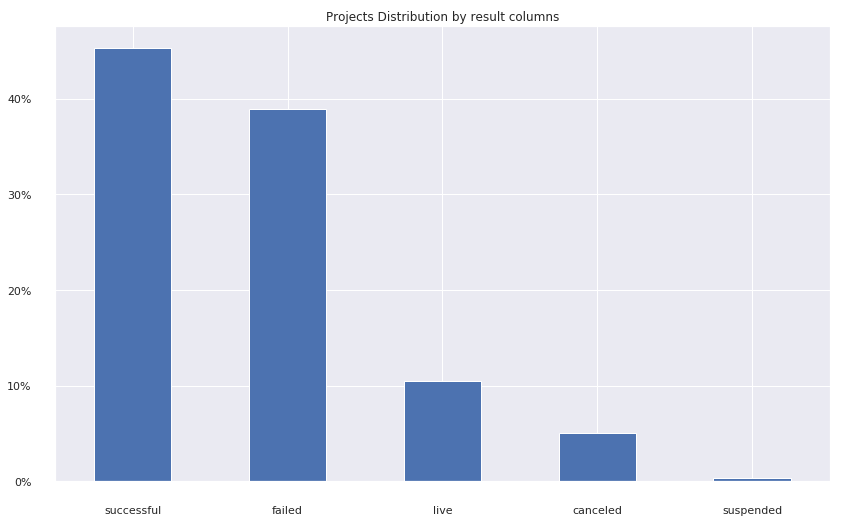

In [29]:
data_result = data.result.value_counts(normalize=True).sort_values(ascending=False)
filename = os.path.join(imagesdir, 'projects_by_result.png')
plot(data_result, filename, title='Projects Distribution by result columns', kind='bar', y_format='pct', x_rot=0)

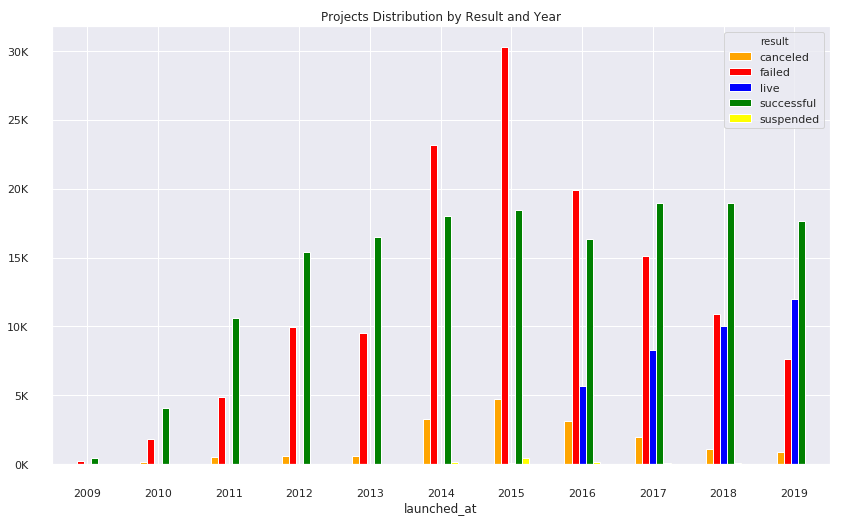

In [30]:
year_projs = data.pivot_table(index = pd.Grouper(key='launched_at', freq='Y'),columns='result', aggfunc='size')
year_projs.index = year_projs.index.year
filename = os.path.join(imagesdir, 'projects_by_result_by_year.png')
plot(year_projs, filename, colors=['orange', 'red', 'blue', 'green', 'yellow'], kind='bar',
     title='Projects Distribution by Result and Year', y_format='K', x_rot=0)

In [31]:
del data_result, year_projs

#### B. Spotlight vs Result.

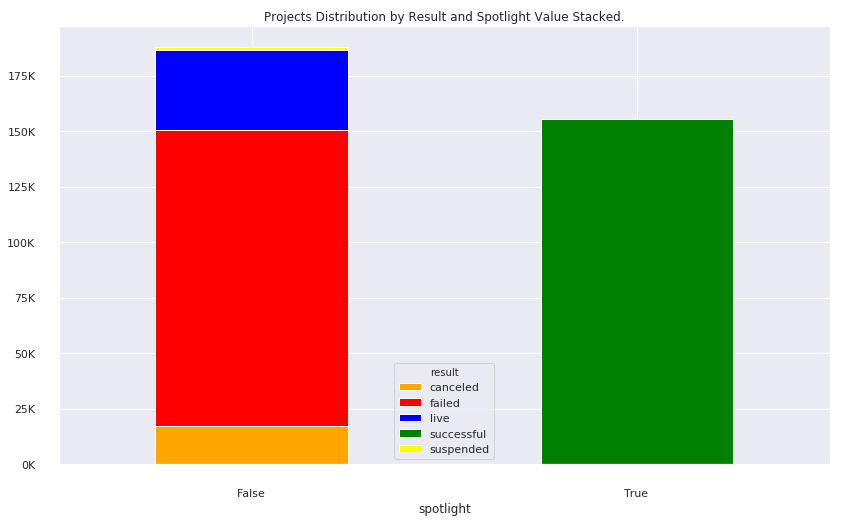

We see that Spotlight is directly related to the result of the project and ith as value Trueonly if the project was successful and False otherwise. This way we ca nget rid of the column asit does not add valuable information


In [32]:
spotlight_projs = data.groupby(['spotlight', 'result']).size().unstack()
filename = os.path.join(imagesdir, 'projects_by_result_by_spotlight_stacked.png')
plot(spotlight_projs, filename, colors=['orange', 'red', 'blue', 'green', 'yellow'], stacked=True, kind='bar',
     title='Projects Distribution by Result and Spotlight Value Stacked.', y_format='K', x_rot=0)

print('We see that Spotlight is directly related to the result of the project and ith as value True\
only if the project was successful and False otherwise. This way we ca nget rid of the column as\
it does not add valuable information')

In [33]:
# Drop spotlight column.
data.drop('spotlight', inplace=True, axis=1)
# Pick only [successful or failed] projects.
data = data[data.result.isin(['successful', 'failed'])].copy()
# Lets change tcolumn to Categorical type
data['result'] = data.result.astype(
        CategoricalDtype(categories=['failed', 'successful'], ordered=False)
)
data.result.describe()

count         288818
unique             2
top       successful
freq          155390
Name: result, dtype: object

In [34]:
del spotlight_projs

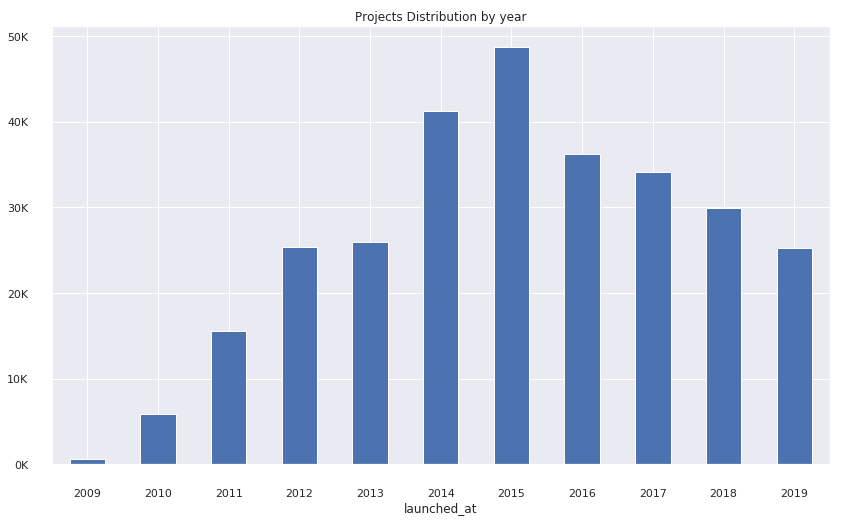

In [35]:
year_projs = data.groupby(pd.Grouper(key='launched_at', freq='Y')).size()
year_projs.index = year_projs.index.year
filename = os.path.join(imagesdir, 'projects_by_year.png')
plot(year_projs, filename, title='Projects Distribution by year', kind='bar', y_format='K', x_rot=0)

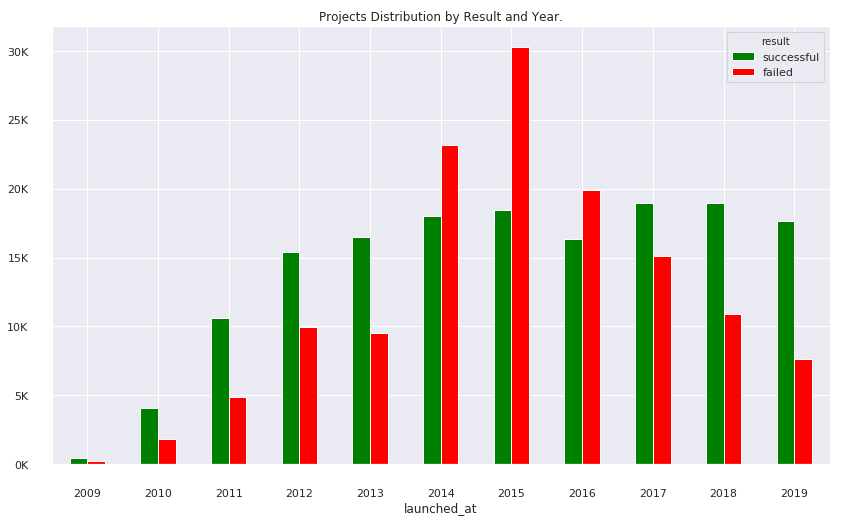

In [36]:
# Study per year products state with two possible values only.
year_projs = data.pivot_table(index = pd.Grouper(key='launched_at', freq='Y'), 
                              columns='result', aggfunc='size')[['successful', 'failed']]
year_projs.index = year_projs.index.year
filename = os.path.join(imagesdir, 'projects_result_bool_by_year.png')
plot(year_projs, filename, colors=['green', 'red'], stacked=False, y_format='K', x_rot=0,
     kind='bar', title='Projects Distribution by Result and Year.')

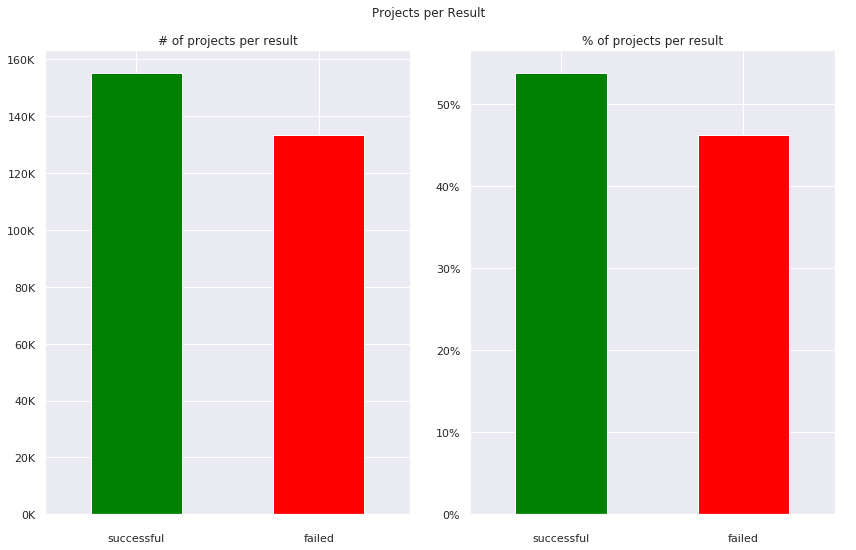

We can see that the distribution of projects per result is not very unbalanced.We have slightly more successful projects than failes ones.


In [37]:
# Study total number of projects as % only for successful and failed projects
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121)
data.result.value_counts().sort_index(ascending=False).plot(kind='bar', ax=ax, color=['green', 'red'])
ax.xaxis.set_tick_params(labelrotation=0, size=15)
ax.set_yticklabels(['{:.0f}K'.format(x/1000) for x in ax.get_yticks()])
ax.set_title('# of projects per result')
ax = fig.add_subplot(122)
data.result.value_counts(normalize=True).sort_index(ascending=False).plot(kind='bar', ax=ax, color=['green', 'red'])
ax.xaxis.set_tick_params(labelrotation=0, size=15)
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
ax.set_title('% of projects per result')
fig.suptitle('Projects per Result')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
filename = os.path.join(imagesdir, 'projs_per_result.png')
fig.savefig(filename, dpi=fig.dpi)
plt.show()

print("We can see that the distribution of projects per result is not very unbalanced.\
We have slightly more successful projects than failes ones.")

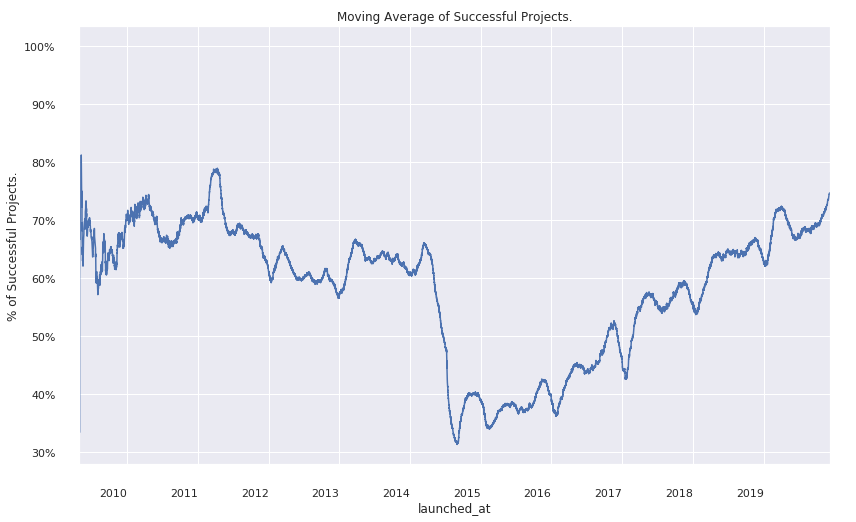

In [38]:
# Lets study the moving average successful results.
data_date_idx = data.set_index('launched_at').sort_index()
ma_success = data_date_idx.result.apply(lambda x: x == 'successful').rolling('60D').mean()
filename = os.path.join(imagesdir, 'ma_successful_projs.png')
plot(ma_success, filename, title='Moving Average of Successful Projects.', kind='line',
     y_format='pct', y_label='% of Successful Projects.')


In [39]:
del year_projs, ma_success, data_date_idx

####  C. Goal_usd vs Result

In [40]:
data.goal_usd.describe()

count    2.888180e+05
mean     3.429322e+04
std      9.378966e+05
min      1.000000e-02
25%      1.600000e+03
50%      5.000000e+03
75%      1.337207e+04
max      1.523501e+08
Name: goal_usd, dtype: float64

In [41]:
result_projs = data.groupby('result')
result_projs.goal_usd.describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
failed,133428.0,63309.051111,1.379015e+06,0.79741,2500.0,7000.000000,20000.0,1.523501e+08
successful,155390.0,9378.327374,2.699807e+04,0.01000,1200.0,3681.398997,10000.0,2.003273e+06


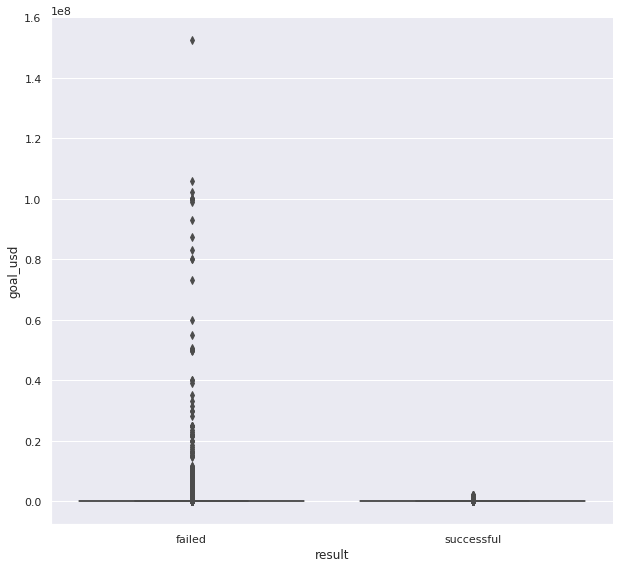

In [42]:
sns.catplot(data=data, x='result', y='goal_usd', kind='box', height=8, aspect=1.1)

In [43]:
max_goal = 100000
min_goal = 150
sum((data['goal_usd'] > min_goal) & (data['goal_usd'] < max_goal)) / data.shape[0]

0.9452873435866186

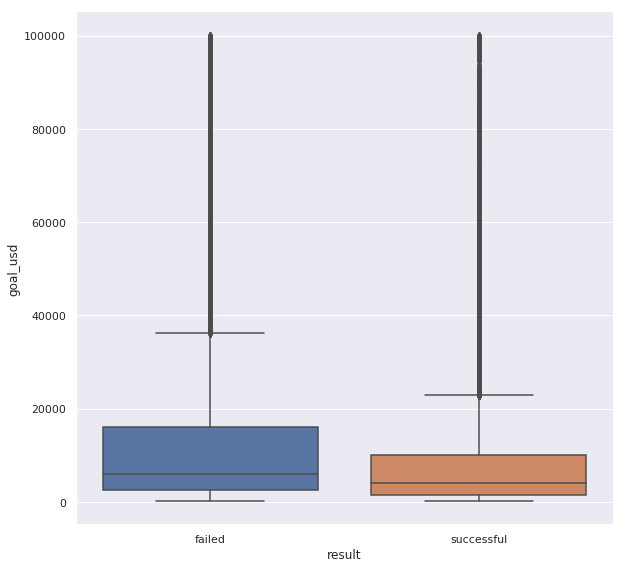

In [44]:
df = data[(data['goal_usd'] > min_goal) & (data['goal_usd'] < max_goal)].copy()

sns.catplot(data=df, x='result', y='goal_usd', kind='box', height=8, aspect=1.1)

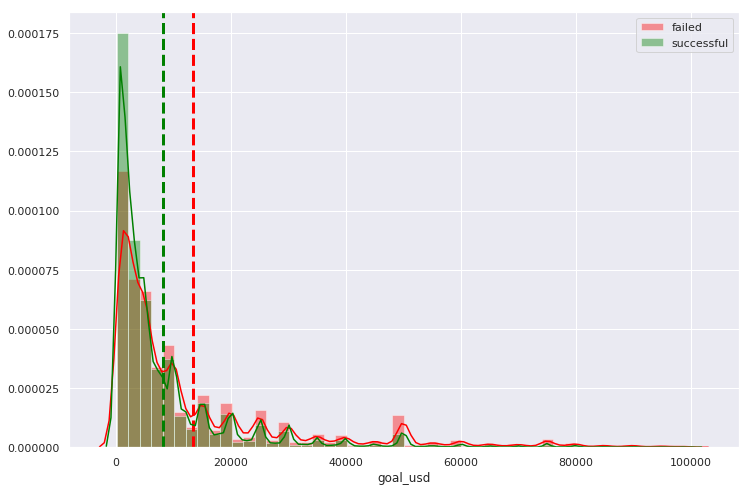

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for name, group in df.groupby('result'):
    if name == 'successful':
        sns.distplot(group['goal_usd'], kde=True, ax=ax, color='green', label=name)
        plt.axvline(np.mean(group['goal_usd']), color='green', linestyle='dashed', linewidth=3)
    else:
        sns.distplot(group['goal_usd'], kde=True, ax=ax, color='red', label=name)
        plt.axvline(np.mean(group['goal_usd']), color='red', linestyle='dashed', linewidth=3)
ax.legend()

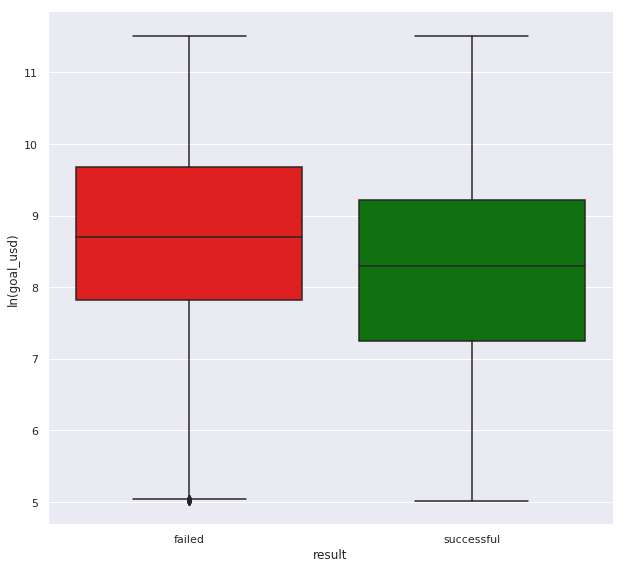

In [46]:
df['ln(goal_usd)'] = np.log(df['goal_usd'])

sns.catplot(data=df, x='result', y='ln(goal_usd)', kind='box', height=8, aspect=1.1, palette=['red', 'green'])

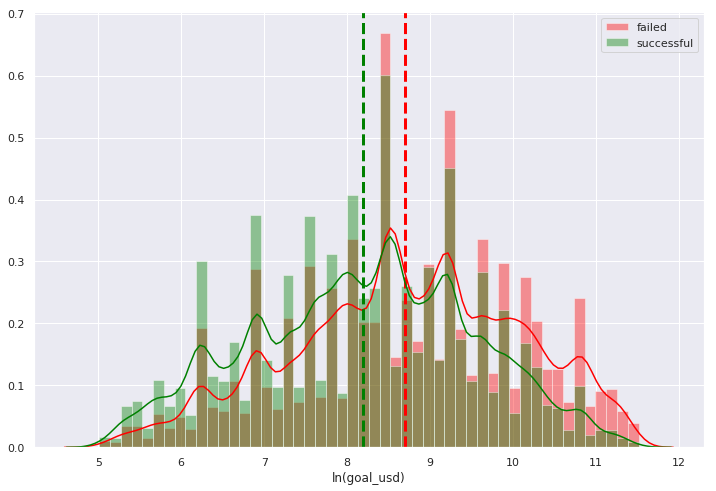

In [47]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

for name, group in df.groupby('result'):
    if name == 'successful':
        sns.distplot(group['ln(goal_usd)'], kde=True, ax=ax, color='green', label=name)
        plt.axvline(np.mean(group['ln(goal_usd)']), color='green', linestyle='dashed', linewidth=3)
    else:
        sns.distplot(group['ln(goal_usd)'], kde=True, ax=ax, color='red', label=name)
        plt.axvline(np.mean(group['ln(goal_usd)']), color='red', linestyle='dashed', linewidth=3)
ax.legend()

We can see how the distribution when aplied a logarithmic transformation gets the shape of a normal distribution.

Lets check whether the mean of goal_usd has equal means for successful and failed projects. We will use a T-test approach, which assumes that variances between our two groups are not equal.

In [48]:
df_fail = df[df.result == 'failed']
df_success = df[df.result == 'successful']
alpha = 0.05
n_fail = df_fail.shape[0]
n_success = df_success.shape[0]
assert n_fail + n_success == df.shape[0], "Lengths of groups do not match lenght of data"

t_value, p_value = stats.ttest_ind(df_fail.goal_usd, df_success.goal_usd, equal_var=False)

print("t-value = " + str(t_value))
print("p-value = {:.5f}".format(p_value))
if p_value > alpha:
    print("We fail to reject the null hypothesis (H0 = equal means)")
else:
    print("We reject the null hypothesis with a confidence interval of {:.0%}".format(alpha))
    print("This way we can conclude that the gorups are statisticaly different")

t-value = 90.17427572474027
p-value = 0.00000
We reject the null hypothesis with a confidence interval of 5%
This way we can conclude that the gorups are statisticaly different


In [49]:
t_value, p_value = stats.ttest_ind(df_fail['ln(goal_usd)'], df_success['ln(goal_usd)'], equal_var=False)

print("t-value = " + str(t_value))
print("p-value = {:.5f}".format(p_value))
if p_value > alpha:
    print("We fail to reject the null hypothesis (H0 = equal means)")
else:
    print("We reject the null hypothesis with a confidence interval of {:.0%}".format(alpha))

t-value = 97.35276538553579
p-value = 0.00000
We reject the null hypothesis with a confidence interval of 5%


Lets check if there is a tendency for binning the values of goal_usd according to result.

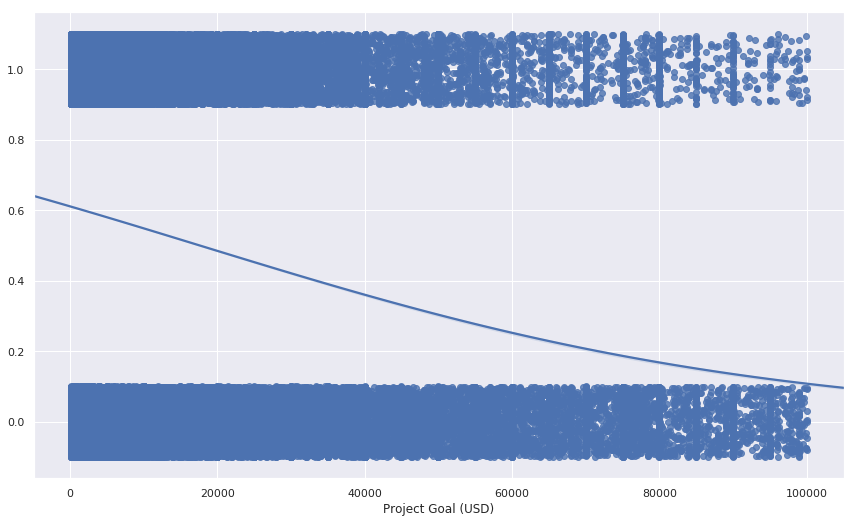

In [50]:
filename = os.path.join(imagesdir, 'result_by_goal_usd_regplot.png')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.regplot(
    x = 'goal_usd',
    y = df.result.cat.codes,
    data = df,
    logistic = True,
    n_boot = 10,
    scatter = True,
    y_jitter = 0.1,
    x_jitter= 0.05,
    ax = ax
);
ax.xaxis.set_label_text('Project Goal (USD)')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(filename, dpi=fig.dpi)
plt.show()

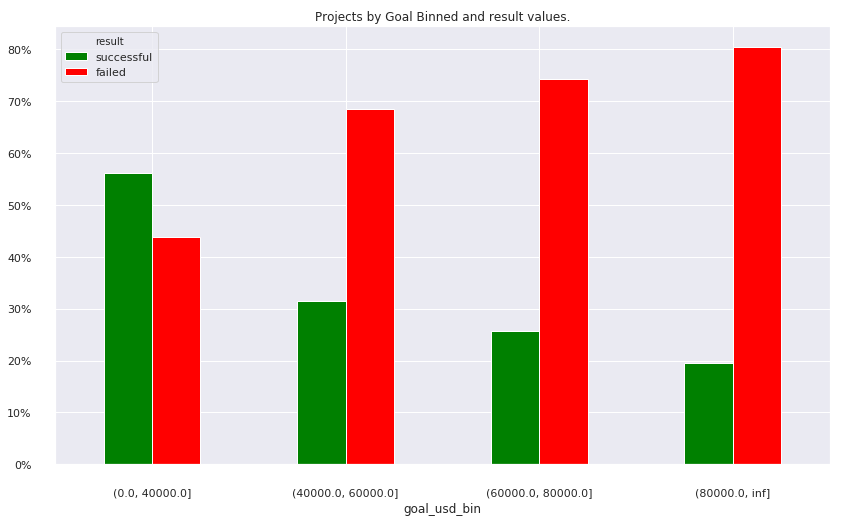

In [51]:
df['goal_usd_bin'] = pd.cut(df['goal_usd'], bins =[0, 40000, 60000, 80000, np.inf])
bin_goal_projs = df.pivot_table(index='goal_usd_bin', columns='result', aggfunc='size')[['successful', 'failed']]
bin_goal_projs = bin_goal_projs.apply(lambda x: x / sum(x), axis=1).sort_values(by='successful', ascending=False)
filename = os.path.join(imagesdir, 'projects_by_result_by_goal_bin.png')
plot(bin_goal_projs, filename, colors=['green', 'red'], y_format='pct', kind='bar', 
    title='Projects by Goal Binned and result values.')

In [52]:
del result_projs, max_goal, min_goal, df_fail, df_success, alpha, n_fail, n_success, t_value, p_value, bin_goal_projs

#### D. Staff_Pick Value vs Result

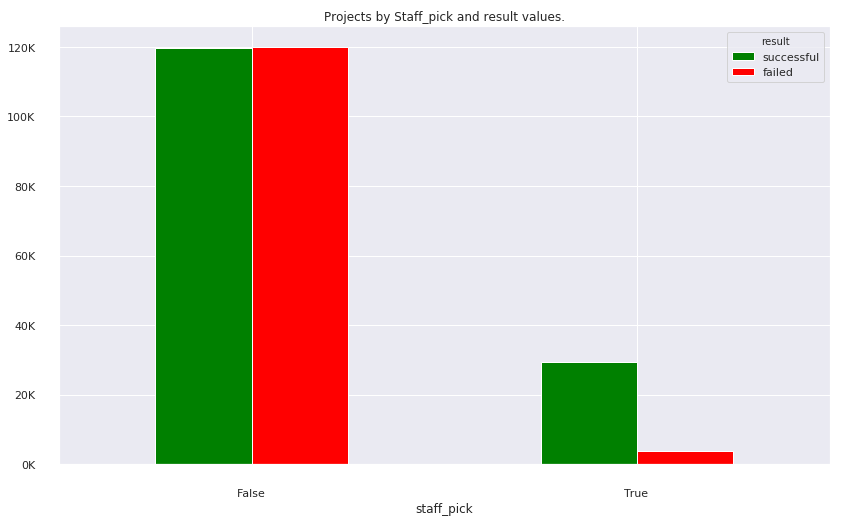

In [53]:
# study project result by staff_pick value
staff_projs = df.pivot_table(index='staff_pick', columns='result', aggfunc='size')[['successful', 'failed']]
filename = os.path.join(imagesdir, 'projects_by_result_by_staffpick.png')
plot(staff_projs, filename, colors=['green', 'red'], y_format='K', kind='bar', 
    title='Projects by Staff_pick and result values.')

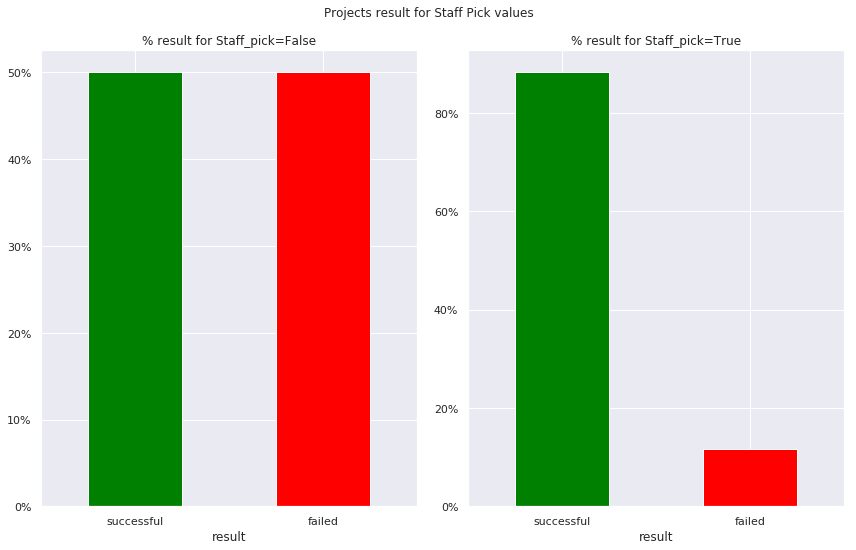

In [54]:
filename = os.path.join(imagesdir, 'result_by_staff_pick.png')
fig = plt.figure(figsize=(12, 8))

for i, value in enumerate(staff_projs.index.values):
    ax = fig.add_subplot(1,2,int(i+1))
    df_pct = staff_projs.loc[value,:] /staff_projs.loc[value,:].sum()
    df_pct[['successful', 'failed']].plot(kind='bar', ax=ax, color=['green', 'red'])
    ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
    ax.xaxis.set_tick_params(rotation= 0)
    ax.set_title('% result for Staff_pick={}'.format(value))
fig.suptitle('Projects result for Staff Pick values') 
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(filename, dpi=fig.dpi)
plt.show()

In [55]:
print("We can see that projects that are selected by the staff have much higher probabilities of success. \
We would make an additional study on what are the characteristics of staff_picked values.")
# TODO: See if we drop the column staff_pick value

We can see that projects that are selected by the staff have much higher probabilities of success. We would make an additional study on what are the characteristics of staff_picked values.


In [56]:
del staff_projs

#### E. Blurb vs Result

First of all lets see if there is a tendency between the blurb length and result of the projects.

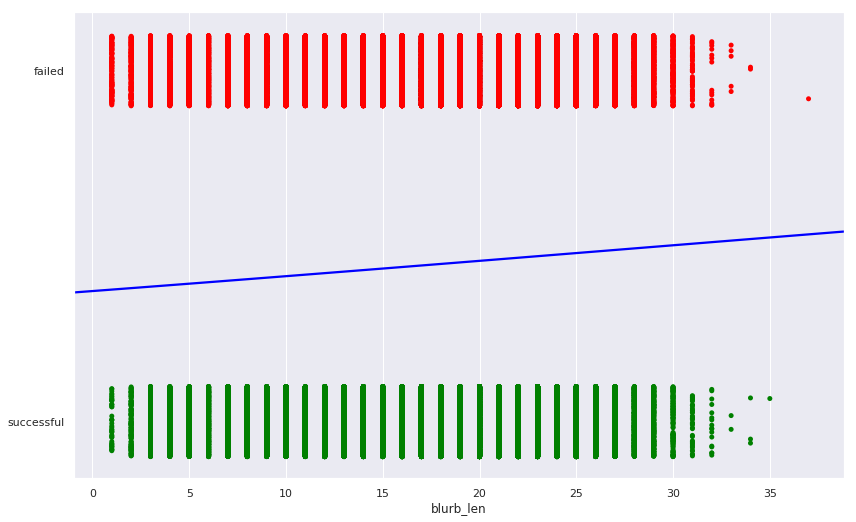

In [57]:
#5-4.2 blurb.
df['blurb_len'] = df.blurb.apply(lambda x: len(x.strip().split()))
filename = os.path.join(imagesdir, 'result_by_blurb_len.png')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df.query('blurb_len < 50'), 
    x = 'blurb_len', 
    y = 'result',
    jitter = 0.1,
    palette=['red', 'green'],
    ax = ax
)
sns.regplot(
    data = df.query('blurb_len <50'),
    x = 'blurb_len',
    y = df.query('blurb_len < 50').result.cat.codes,
    ci = None,
    logistic = True,
    scatter = False,
    line_kws = {'color': 'blue'},
    ax = ax
);
# We put a condition of less than 50 as there is a unique outlier.
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(filename, dpi=fig.dpi)
plt.show()

We do not see a relationship there as the regression line. We neither see a clear way to bin the blurb length in order to have more robust data.

We see that there is no relatoinship in th blur bcolunm so we can drop the related columns


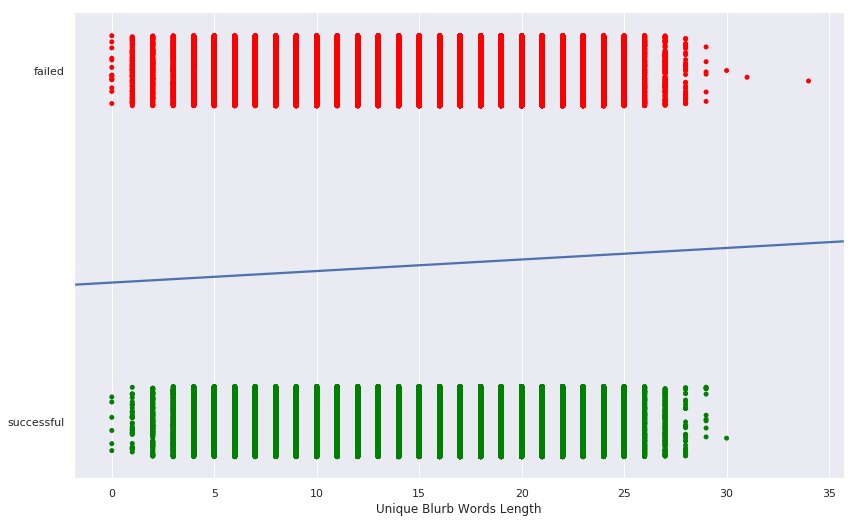

In [58]:
# Check if there is a relation with number of unique words
regex = re.compile("[" + re.escape(string.punctuation) + "]")
blurb_unique_len = df.blurb.apply(lambda x: np.unique(regex.sub("", x).lower().strip().split()).size)
filename = os.path.join(imagesdir, 'result_by_blurb_unique_words.png')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
sns.stripplot(
    x = blurb_unique_len, 
    y = df.result, 
    jitter = 0.1, 
    palette=['red', 'green'],
    ax = ax
)
sns.regplot(
    x = blurb_unique_len,
    y = df.result.cat.codes,
    data = df,
    ci = None,
    scatter=False,
    ax = ax
);
ax.xaxis.set_label_text('Unique Blurb Words Length')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(filename, dpi=fig.dpi)
print("We see that there is no relatoinship in th blur bcolunm so we can drop \
the related columns")

In [59]:
df = remove_cols(df, ['blurb', 'blurb_len'])

Succesfully removed columns ['blurb', 'blurb_len']


In [60]:
del regex, blurb_unique_len

#### F. Slug vs Result

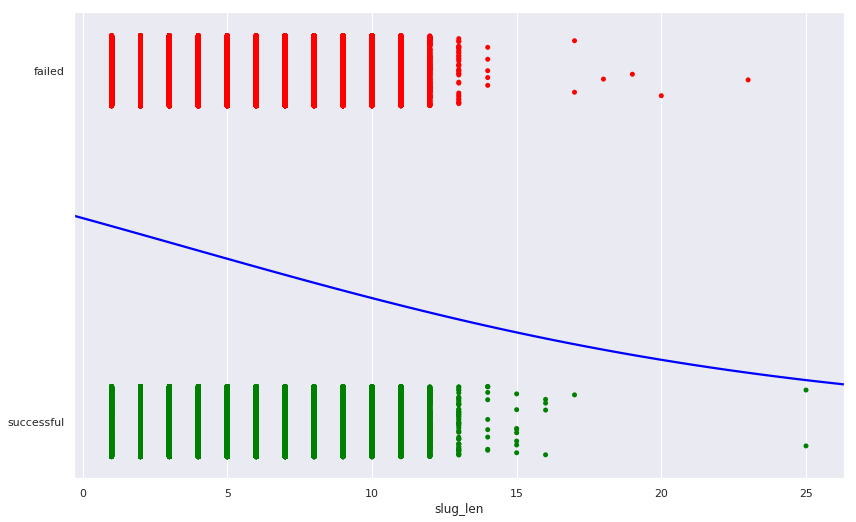

In [61]:
#5-4.3 slug.
df['slug_len'] = df.slug.apply(lambda x: len(x.strip().split('-')))
filename = os.path.join(imagesdir, 'result_by_slug_len.png')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df, 
    x = 'slug_len', 
    y = 'result', 
    palette = ['red', 'green'],
    jitter = 0.1,
    ax = ax
)
sns.regplot(
    x = df['slug_len'],
    y = df['result'].cat.codes,
    ci = None,
    logistic = True,
    scatter = False,
    line_kws = {"color": "blue"},
    ax = ax
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(filename, dpi=fig.dpi)
plt.show()

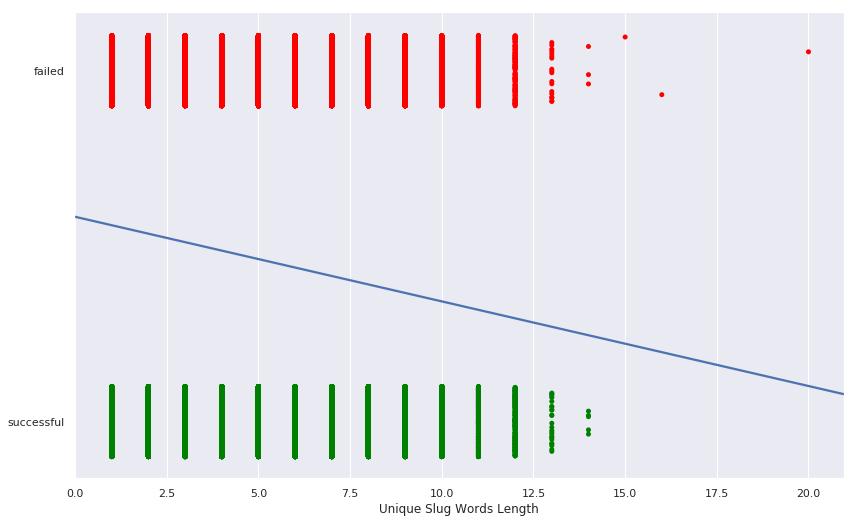

In [62]:
slug_unique_len = df.slug.apply(lambda x: np.unique(x.strip().split('-')).size)        
filename = os.path.join(imagesdir, 'result_by_slug_unique_words.png')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    x = slug_unique_len, 
    y = df['result'],
    palette = ['red', 'green'],
    jitter = 0.1, 
    ax = ax
)

sns.regplot(
        x = slug_unique_len,
        y = df.result.cat.codes,
        data = df,
        ci = None,
        scatter=False,
        ax = ax
);
ax.xaxis.set_label_text('Unique Slug Words Length')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig(filename, dpi=fig.dpi)
plt.show()

In [63]:
df = remove_cols(df, ['slug_len'])

Succesfully removed columns ['slug_len']


In [64]:
del slug_unique_len

#### G. Main Category vs. Result

Set main_category as categorical type column

In [66]:
df['main_category'] = df['main_category'].astype('category')

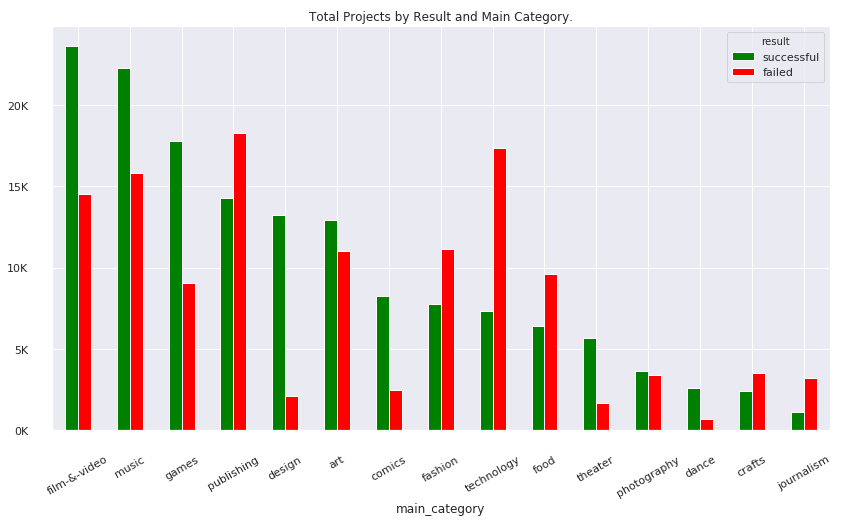

In [67]:
main_cat_projs = df.pivot_table(index='main_category', columns='result', aggfunc='size')[['successful', 'failed']]
main_cat_projs.sort_values(by='successful', ascending=False, inplace=True)

filename = os.path.join(imagesdir, 'projects_result_by_main_category.png')
plot(main_cat_projs, filename, colors=['green', 'red'], stacked=False, y_format='K', x_rot=30,
     kind='bar', title='Total Projects by Result and Main Category.')

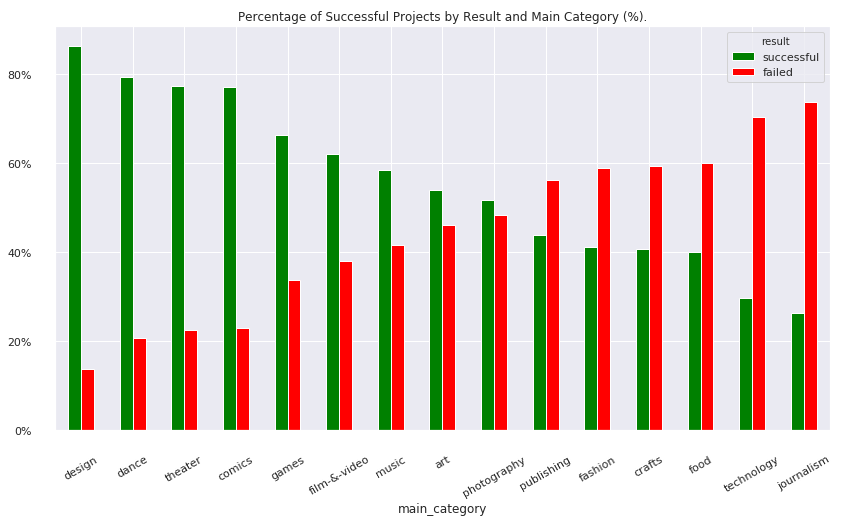

In [68]:
main_cat_projs_pct = main_cat_projs.apply(lambda x: x / sum(x), axis=1)
main_cat_projs_pct.sort_values(by='successful', ascending=False, inplace=True)
filename = os.path.join(imagesdir, 'projects_result_by_main_category_pct.png')
plot(main_cat_projs_pct, filename, colors=['green', 'red'], stacked=False, y_format='pct', x_rot=30,
     kind='bar', title='Percentage of Successful Projects by Result and Main Category (%).')

In [69]:
del main_cat_projs, main_cat_projs_pct

#### H. Sub-category vs. Result

In [70]:
df['sub_category'].nunique()

146

We have a lot of values for sub_category columns that are empty strings.

#### I. Country vs Result.

In [71]:
# Number of unique countries.
df['country'].nunique()

203

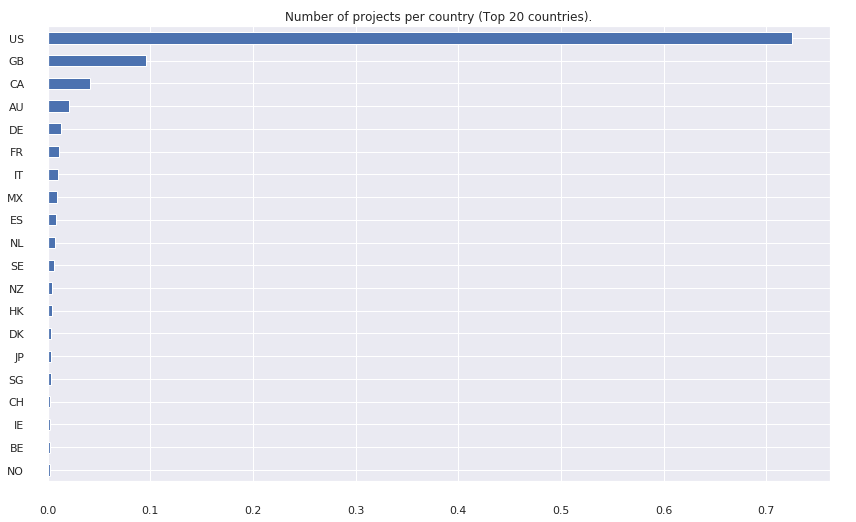

In [72]:
country_projs = df['country'].value_counts(normalize = True, sort = True, ascending=True)
filename = os.path.join(imagesdir, 'projects_by_bountry.png')

plot(country_projs[-20::], filename, kind='barh', title='Number of projects per country (Top 20 countries).')

We see that we have more than 200 distinct countries but US accounts for more than 70% of total projects. This way we will focus on US projects

In [73]:
df_us = df[df['country'] == 'US'].copy()
df_us = remove_cols(df_us, ['country'])

Succesfully removed columns ['country']


In [74]:
del country_projs

#### J. Days until Launch vs Result

In [75]:
# 5-4-5 Study duration.
df_us['days_until_launch'] = (df_us.launched_at - df_us.created_at).dt.days

df_us.groupby('result')['days_until_launch'].describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
failed,88445.0,43.805495,129.036608,0.0,2.0,7.0,29.0,3190.0
successful,109596.0,50.793487,132.899295,0.0,4.0,15.0,42.0,3303.0


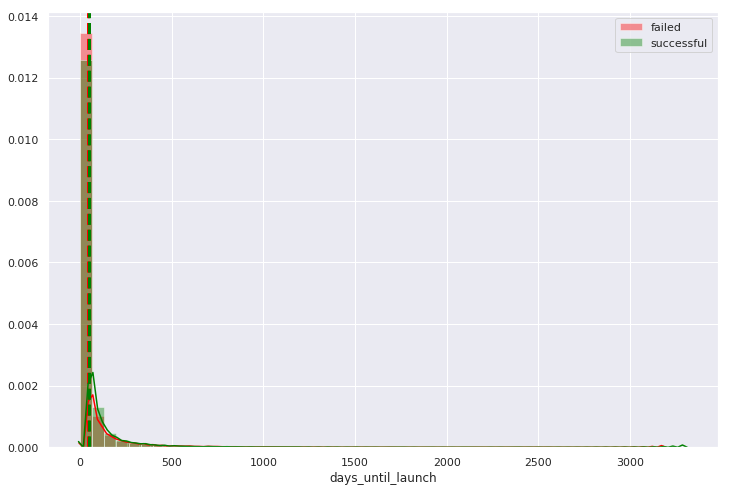

In [76]:
fig = plt.figure(figsize=(12, 8))
ax= fig.add_subplot(111)

for name, group in df_us.groupby('result'):
    if name == 'successful':
        sns.distplot(group['days_until_launch'], kde=True, ax=ax, color='green', label=name)
        plt.axvline(np.mean(group['days_until_launch']), color='green', linestyle='dashed', linewidth=3)
    else:
        sns.distplot(group['days_until_launch'], kde=True, ax=ax, color='red', label=name)
        plt.axvline(np.mean(group['days_until_launch']), color='red', linestyle='dashed', linewidth=3)
ax.legend()

In [77]:
df_us_fail = df_us[df_us.result == 'failed']
df_us_success = df_us[df_us.result == 'successful']
alpha = 0.05
n_fail = df_us_fail.shape[0]
n_success = df_us_success.shape[0]
assert n_fail + n_success == df_us.shape[0], "Lengths of groups do not match lenght of data"

t_value, p_value = stats.ttest_ind(df_us_fail['days_until_launch'], df_us_success['days_until_launch'], equal_var=False)

print("t-value = " + str(t_value))
print("p-value = {:.5f}".format(p_value))
if p_value > alpha:
    print("We fail to reject the null hypothesis (H0 = equal means)")
else:
    print("We reject the null hypothesis with a confidence interval of {:.0%}".format(alpha))
    print("This way we can conclude that the gorups are statisticaly different")

t-value = -11.821743127019653
p-value = 0.00000
We reject the null hypothesis with a confidence interval of 5%
This way we can conclude that the gorups are statisticaly different


In [78]:
df_us.query('days_until_launch < 100').shape[0] / df_us.shape[0]

0.8936230376538191

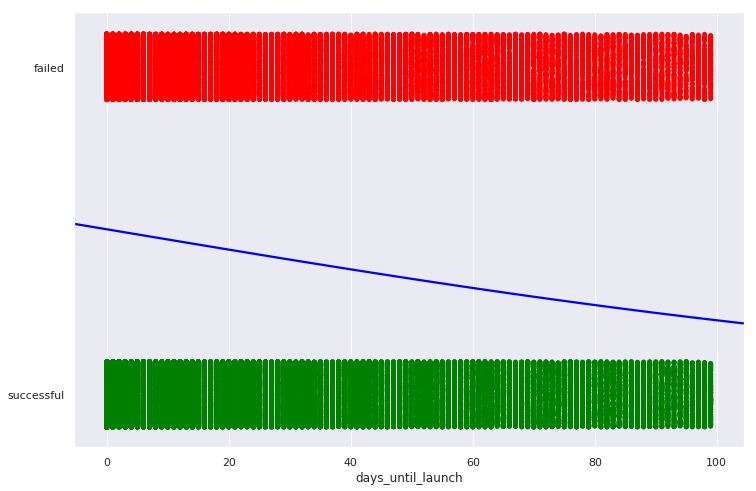

In [79]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df_us.query('days_until_launch < 100'), 
    x = 'days_until_launch', 
    y = 'result',
    palette = ['red', 'green'],
    jitter = 0.1, 
    ax = ax
)

sns.regplot(
    x = 'days_until_launch',
    y = df_us.query('days_until_launch < 100').result.cat.codes,
    data = df_us.query('days_until_launch < 100'),
    ci = None,
    scatter = False,
    logistic = True,
    line_kws = {"color": "blue"},
    ax = ax
)

plt.show()

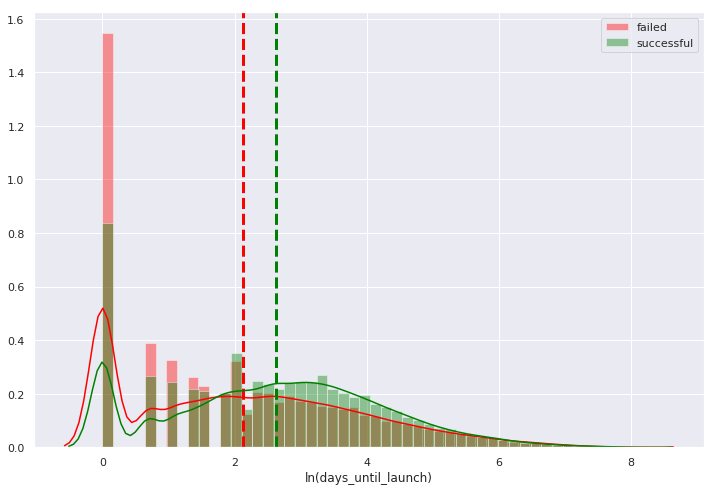

In [80]:
df_us['ln(days_until_launch)'] = df_us['days_until_launch'].apply(
    lambda x: np.log(x) if x > 0 else 0)

fig = plt.figure(figsize=(12, 8))
ax= fig.add_subplot(111)

for name, group in df_us.groupby('result'):
    if name == 'successful':
        sns.distplot(group['ln(days_until_launch)'], kde=True, ax=ax, color='green', label=name)
        plt.axvline(np.mean(group['ln(days_until_launch)']), color='green', linestyle='dashed', linewidth=3)
    else:
        sns.distplot(group['ln(days_until_launch)'], kde=True, ax=ax, color='red', label=name)
        plt.axvline(np.mean(group['ln(days_until_launch)']), color='red', linestyle='dashed', linewidth=3)
ax.legend()

<Figure size 864x576 with 0 Axes>

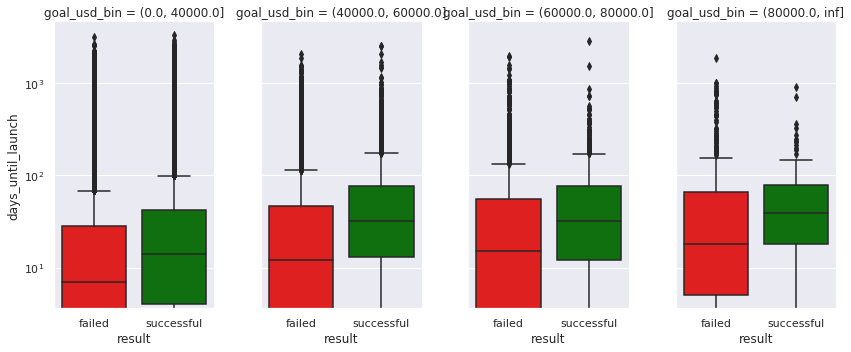

In [81]:
fig = plt.figure(figsize=(12, 8))

g = sns.catplot(x='result', y='days_until_launch', col='goal_usd_bin', palette=['red', 'green'],
            aspect=.6, kind='box', data=df_us);
g.set(yscale='log')

<Figure size 864x576 with 0 Axes>

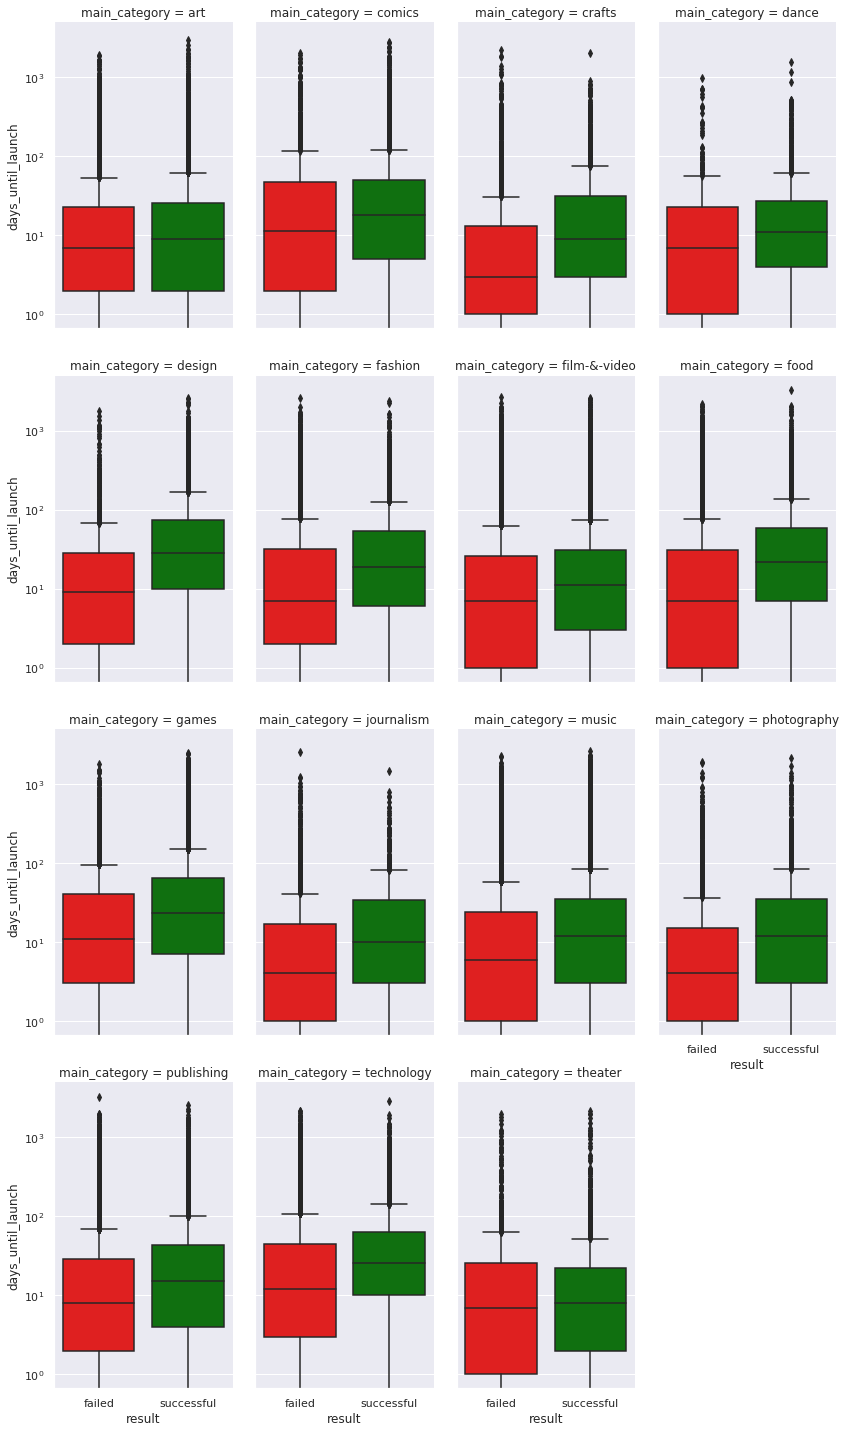

In [82]:
fig = plt.figure(figsize=(12, 8))

g = sns.catplot(x='result', y='days_until_launch', col='main_category', col_wrap=4,
                palette=['red', 'green'], aspect=.6, kind='box', data=df_us);
g.set(yscale='log')

There are not great differences respect to days_until_launch

In [83]:
del df_us_fail, df_us_success, n_fail, n_success, t_value, p_value, alpha, g

#### K. Currency vs Result

In [84]:
curr_projs = df_us['currency'].value_counts(normalize=True, sort=True)
df_us.currency.unique()

array(['USD', 'EUR', 'GBP', 'CHF', 'CAD', 'SGD', 'SEK', 'DKK', 'AUD',
       'NZD', 'NOK', 'MXN', 'HKD', 'JPY'], dtype=object)

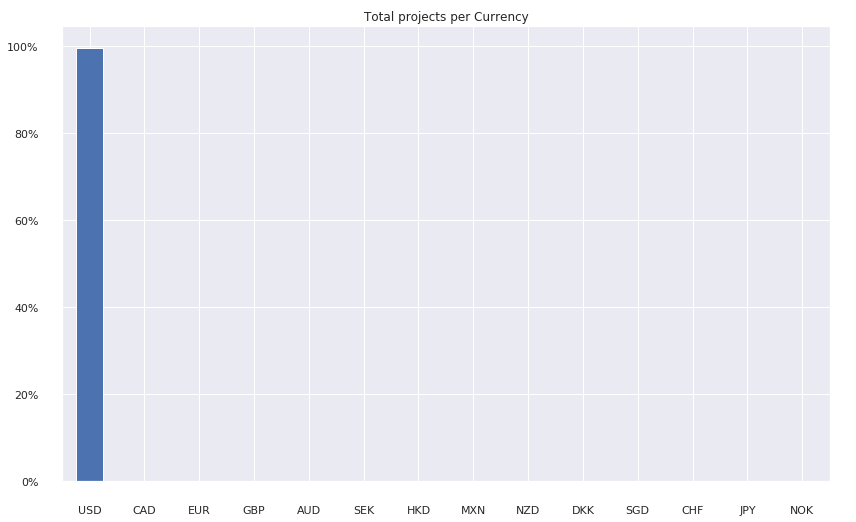

In [85]:
filename = os.path.join(imagesdir, 'projects_by_currency.png')
plot(curr_projs, filename, title='Total projects per Currency', kind='bar', y_format='pct')

In [86]:
print('{:<15}{:>15}'.format('Currency', '% of Total Projects'))
[print('{:<15}{:>15.1%}'.format(curr, value)) for curr, value in curr_projs.items()]

Currency       % of Total Projects
USD                      99.5%
CAD                       0.2%
EUR                       0.1%
GBP                       0.1%
AUD                       0.0%
SEK                       0.0%
HKD                       0.0%
MXN                       0.0%
NZD                       0.0%
DKK                       0.0%
SGD                       0.0%
CHF                       0.0%
JPY                       0.0%
NOK                       0.0%


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

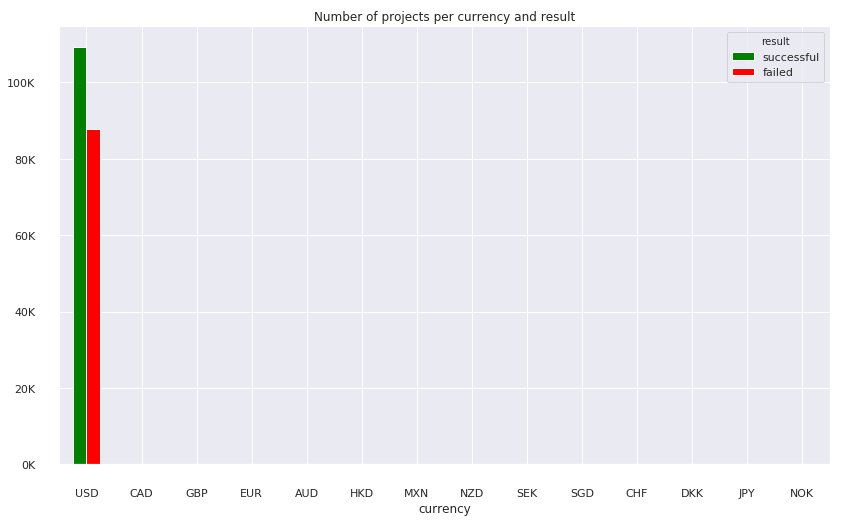

In [87]:
result_curr_projs = df_us.pivot_table(index='currency', columns='result', aggfunc='size')
result_curr_projs.sort_values(by = 'successful', ascending=False, inplace=True)
filename = os.path.join('projects_by_currency_by_result.png')

plot(result_curr_projs[['successful', 'failed']], filename, title='Number of projects per currency and result',
     y_format='K', colors=['green', 'red'])

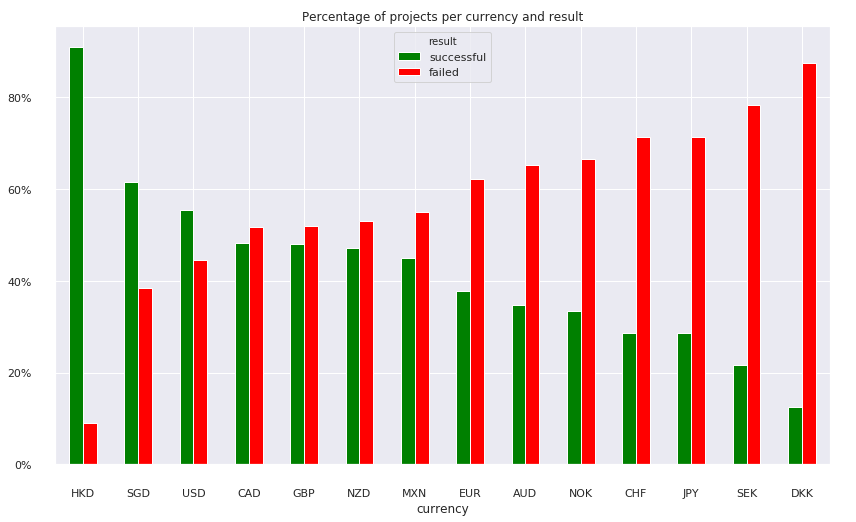

In [88]:
result_curr_projs_pct = result_curr_projs.apply(lambda x: x / sum(x), axis=1)
result_curr_projs_pct.sort_values(by='successful', ascending=False, inplace = True)
filename = os.path.join('projects_by_currency_by_result_pct.png')

plot(result_curr_projs_pct[['successful', 'failed']], filename, title='Percentage of projects per currency and result',
     y_format='pct', colors=['green', 'red'])

As we have mainly only USD currency projetcs, and the number of projects in other currency is not very statiscally relevant (< 1 %), we will not use this column for our models.

In [89]:
df_us = remove_cols(df_us, ['currency'])

Succesfully removed columns ['currency']


In [90]:
del curr_projs, result_curr_projs, result_curr_projs_pct

#### K. State vs Result.

In [91]:
df_us.state.unique()

array(['MD', 'NY', 'NJ', 'HI', 'AL', 'CA', 'MA', 'MN', 'GA', 'AZ', 'CT',
       'NC', 'IN', 'TX', 'OH', 'VA', 'KY', 'OR', 'IL', 'FL', 'CO', 'UT',
       'WA', 'PA', 'LA', 'TN', 'MO', 'MI', 'SC', 'SD', 'NV', 'IA', 'DE',
       'NE', 'WI', 'OK', 'AR', 'Gibraltar', 'AK', 'ME', 'KS', 'MT', 'ID',
       'NH', 'Bay of Plenty', 'MS', 'RI', 'DC', 'Waikato', 'Kosovo',
       'Antarctica', 'WV', 'WY', 'VT', 'Curacao', 'NM', 'ND', 'Skopje',
       'Sint Maarten', 'Otago', 'Pitcairn', 'Manawatu Wanganui',
       'Taranaki', 'Macau', 'Vatican', 'Kiribati'], dtype=object)

We have some values of States that do not belong to the US. We see that those values correspond to the countries that had empty state values when we studied missing values. Lets dig to find out why they were categorized as US projects.

In [92]:
df_non_us = df_us[df_us.state.isin(['Gibraltar', 'Bay of Plenty', 'Waikato', 'Kosovo', 'Antarctica', 'Curacao', 'Skopje',
                        'Sint Maarten', 'Otago', 'Pitcairn', 'Manawatu Wanganui', 'Taranaki', 'Macau',
                        'Vatican', 'Kiribati'])]

print("We have a total of {:.1%} US classified projects that do not correspond to US states".format(
    df_non_us.shape[0] / df_us.shape[0]))

We have a total of 2.4% US classified projects that do not correspond to US states


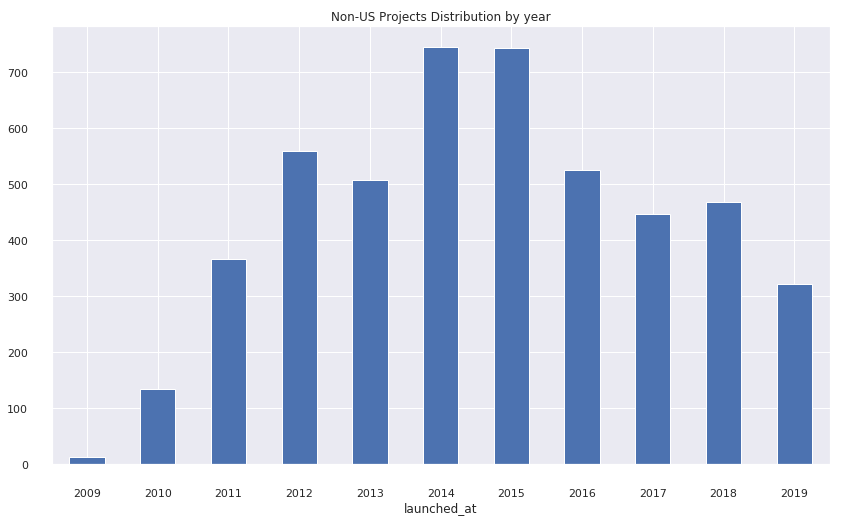

In [89]:
year_projs = df_non_us.groupby(pd.Grouper(key='launched_at', freq='Y')).size()
year_projs.index = year_projs.index.year
filename = os.path.join(imagesdir, 'non_us_projects_by_year.png')
plot(year_projs, filename, title='Non-US Projects Distribution by year', kind='bar', x_rot=0)

We do not see that these miss clasification corresponds to a specific range in time so we drop those projects.

In [90]:
df_us = df_us[~df_us.state.isin(['Gibraltar', 'Bay of Plenty', 'Waikato', 'Kosovo', 'Antarctica', 'Curacao', 'Skopje',
                        'Sint Maarten', 'Otago', 'Pitcairn', 'Manawatu Wanganui', 'Taranaki', 'Macau',
                        'Vatican', 'Kiribati'])].copy()
df_us.shape[0]

193214

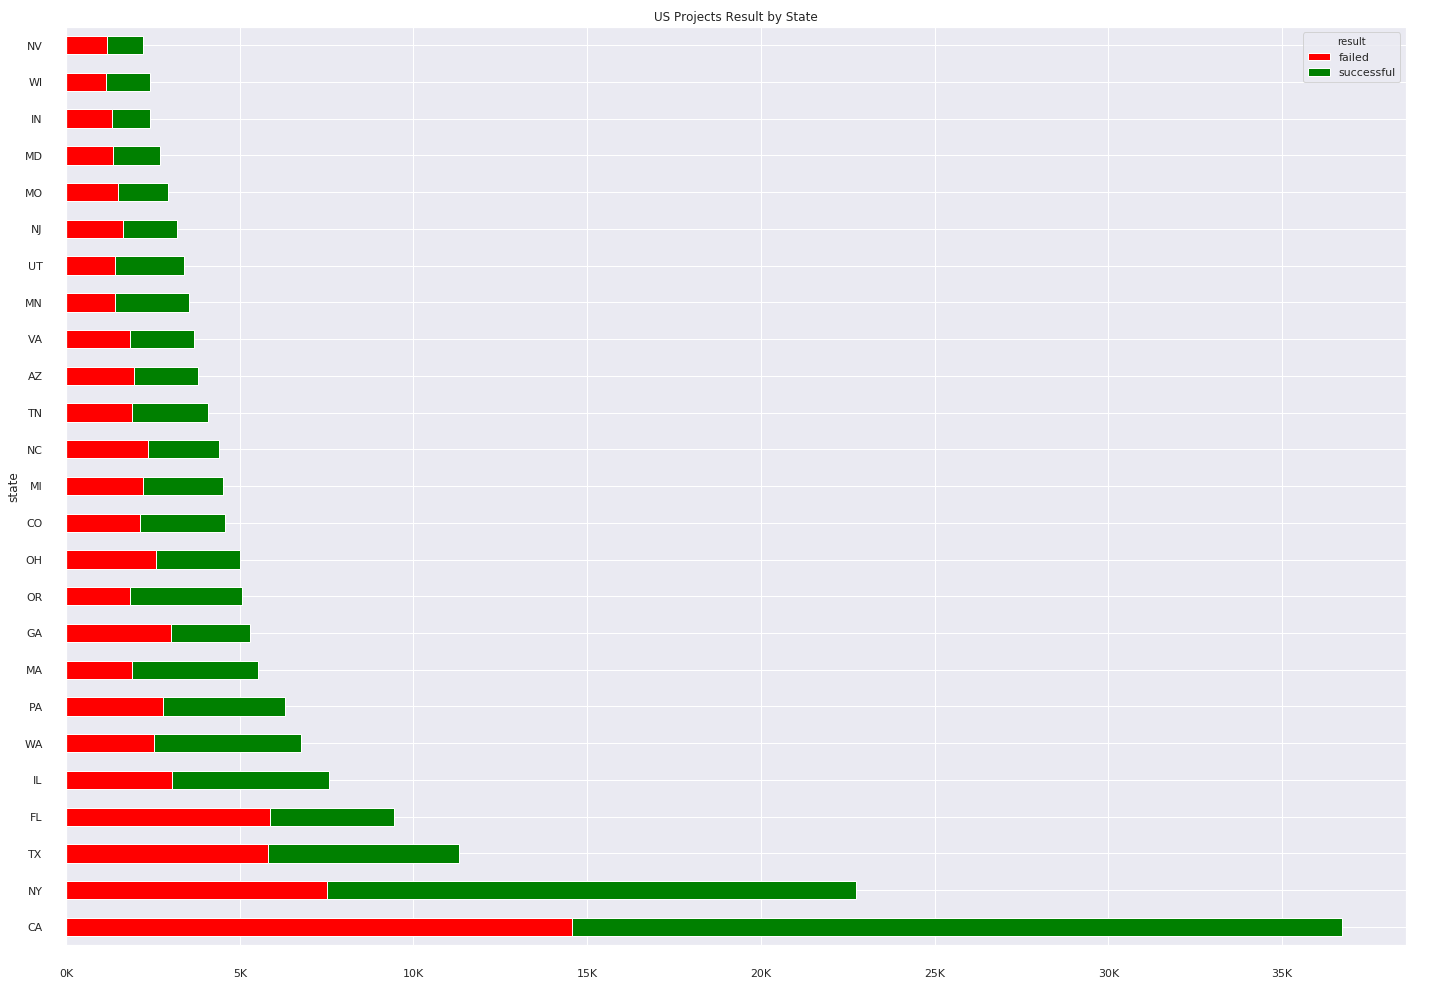

In [91]:
state_projs = df_us.pivot_table(index='state', columns='result', aggfunc='size')
state_projs = state_projs.iloc[np.argsort(state_projs.successful + state_projs.failed)[::-1]]
filename = os.path.join(imagesdir, 'us_projects_by_result_by_state.png')

plot(state_projs[:25], filename, kind='barh', x_format='K', title='US Projects Result by State',
     figsize=(20,15), colors=['red', 'green'], stacked=True)

In [92]:
state_projs[:15].sum().sum() / state_projs.sum().sum()

0.7208639125529206

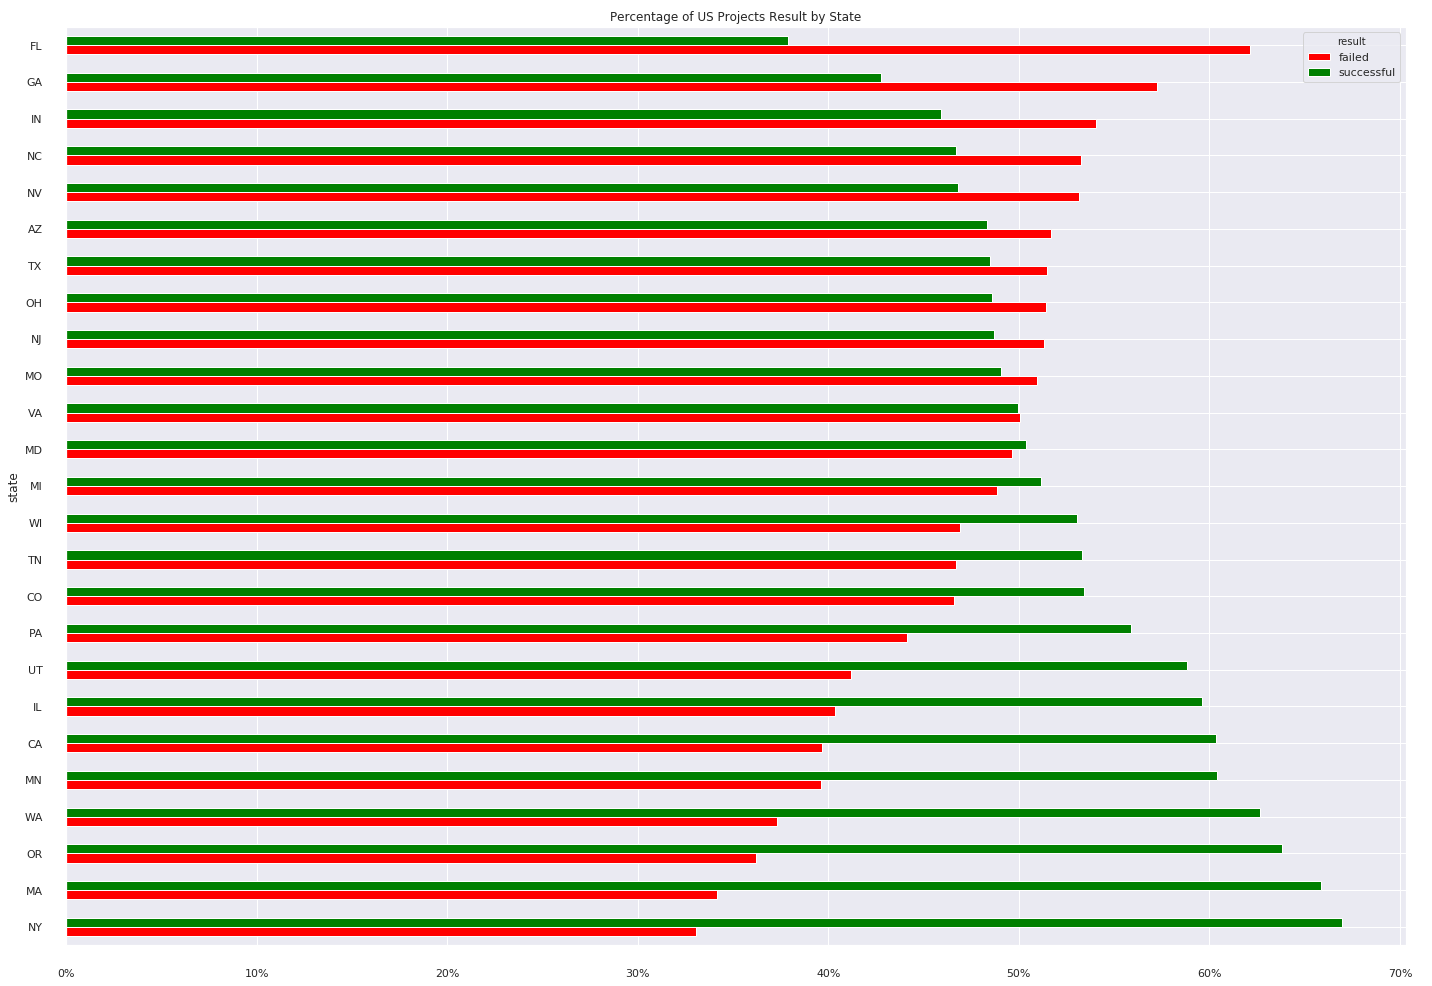

In [93]:
state_projs_pct = state_projs[:25].apply(lambda x: x / sum(x), axis=1).sort_values(by='successful', ascending=False)
filename = os.path.join(imagesdir, 'us_projects_by_result_by_state_pct.png')

plot(state_projs_pct, filename, kind='barh', x_format='pct', title='Percentage of US Projects Result by State',
     figsize=(20,15), colors=['red', 'green'])

In [94]:
del year_projs, state_projs, state_projs_pct

#### L. Cities vs. Result

In [95]:
df_us.city.nunique()

8350

We have a lot of different cities, so we will not use this column.

#### M. Duration vs Result.

In [96]:
# Compute duration.
df_us['duration_in_days'] = (df_us['deadline'] - df_us['launched_at']).dt.total_seconds().apply(lambda x: x / 86400)
df_us['duration_in_days'].describe()

count    193214.000000
mean         33.347098
std          12.315593
min           1.000000
25%          29.958333
50%          30.000000
75%          35.000000
max          97.781782
Name: duration_in_days, dtype: float64

In [97]:
df_us.groupby('result')['duration_in_days'].describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
failed,86330.0,35.023595,13.042605,1.0,30.00000,30.0,40.000000,92.000000
successful,106884.0,31.992995,11.518725,1.0,29.45331,30.0,33.333293,97.781782


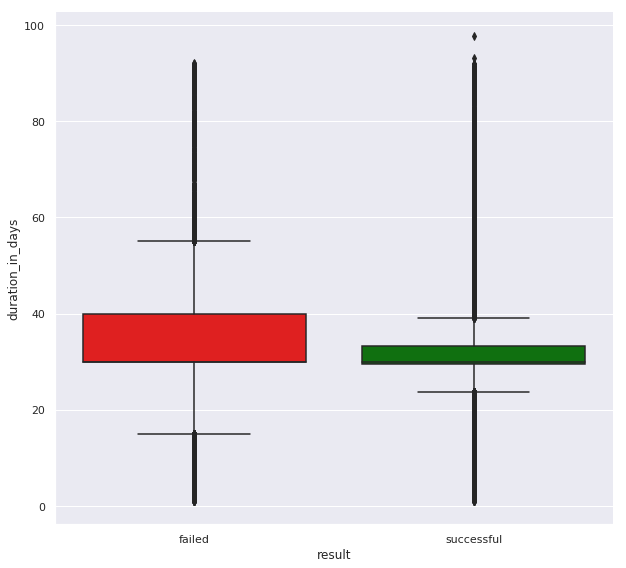

In [98]:
sns.catplot(data=df_us, x='result', y='duration_in_days', kind='box',
            height=8, aspect=1.1, palette=['red', 'green'])

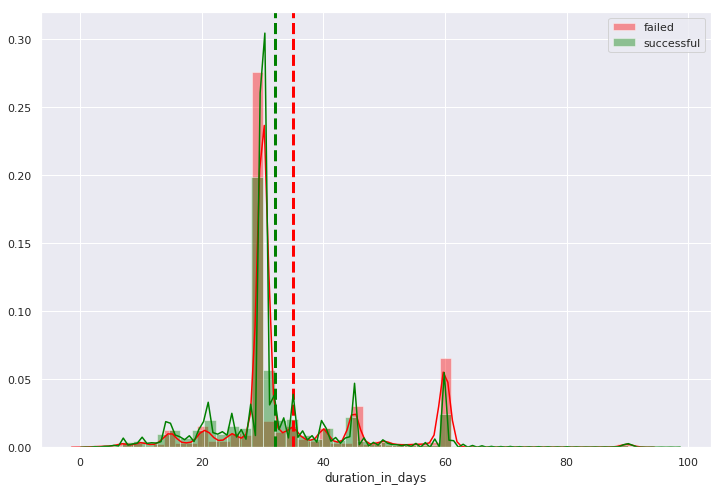

In [99]:
fig = plt.figure(figsize=(12, 8))
ax= fig.add_subplot(111)

for name, group in df_us.groupby('result'):
    if name == 'successful':
        sns.distplot(group['duration_in_days'], kde=True, ax=ax, color='green', label=name)
        plt.axvline(np.mean(group['duration_in_days']), color='green', linestyle='dashed', linewidth=3)
    else:
        sns.distplot(group['duration_in_days'], kde=True, ax=ax, color='red', label=name)
        plt.axvline(np.mean(group['duration_in_days']), color='red', linestyle='dashed', linewidth=3)
ax.legend()

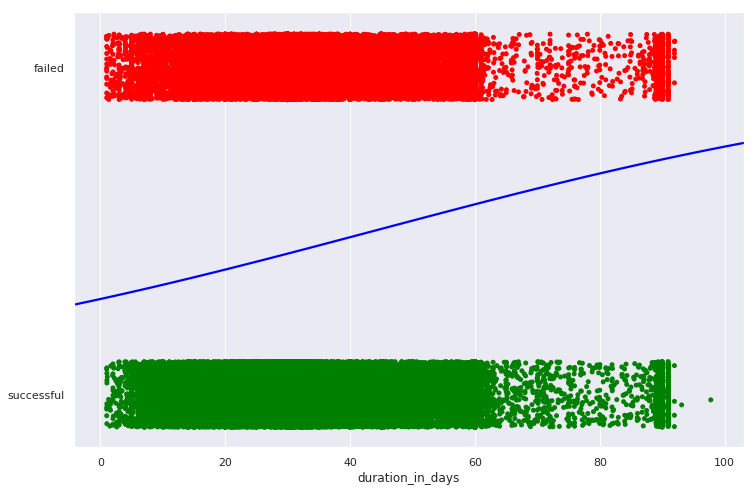

In [100]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df_us, 
    x = 'duration_in_days', 
    y = 'result',
    palette = ['red', 'green'],
    jitter = 0.1, 
    ax = ax
)

sns.regplot(
    x = 'duration_in_days',
    y = df_us.result.cat.codes,
    data = df_us,
    ci = None,
    scatter = False,
    logistic = True,
    line_kws = {"color": "blue"},
    ax = ax
)

plt.show()

Lets bin the duration

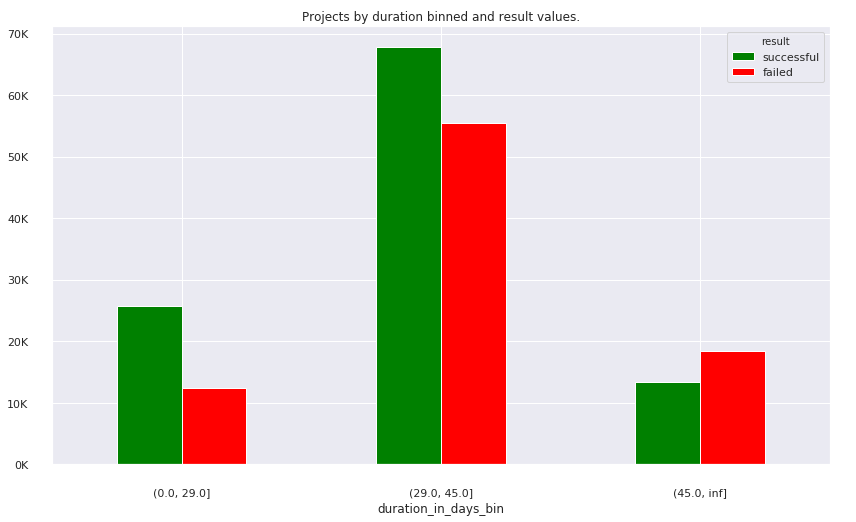

In [101]:
df_us['duration_in_days_bin'] = pd.cut(df_us['duration_in_days'], bins =[0, 29, 45, np.inf])
bin_duration_projs = df_us.pivot_table(index='duration_in_days_bin', columns='result', aggfunc='size')[['successful', 'failed']]
#bin_duration_projs = bin_duration_projs.apply(lambda x: x / sum(x), axis=1).sort_values(by='successful', ascending=False)
filename = os.path.join(imagesdir, 'projects_by_result_by_duration_bin.png')
plot(bin_duration_projs, filename, colors=['green', 'red'], y_format='K', kind='bar', 
    title='Projects by duration binned and result values.')

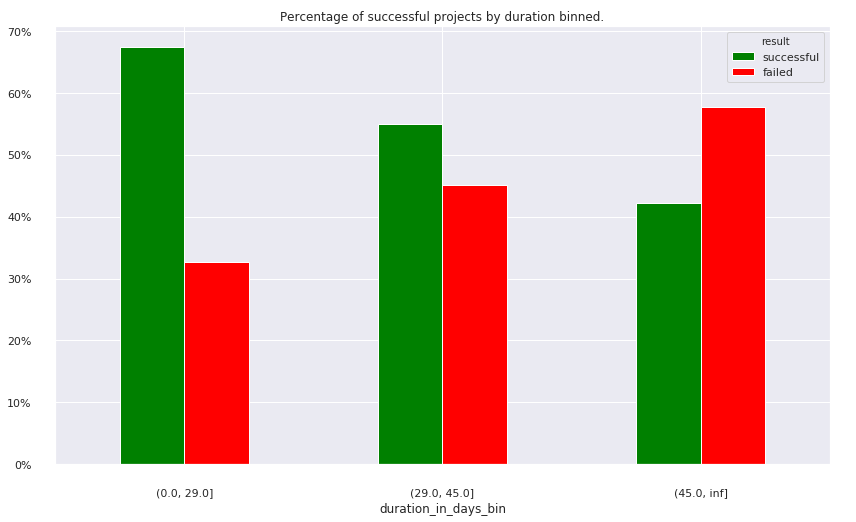

In [102]:
bin_duration_projs_pct = bin_duration_projs.apply(lambda x: x / sum(x), axis=1).sort_values(by='successful', ascending=False)
filename = os.path.join(imagesdir, 'projects_by_result_by_duration_bin_pct.png')
plot(bin_duration_projs_pct, filename, colors=['green', 'red'], y_format='pct', kind='bar', 
    title='Percentage of successful projects by duration binned.')

We already can see that the higher the duration, the less probability of the project campaign to be successful.

#### N. Characteristics of day of launch vs Result

##### N.1 Launched_at day of week.

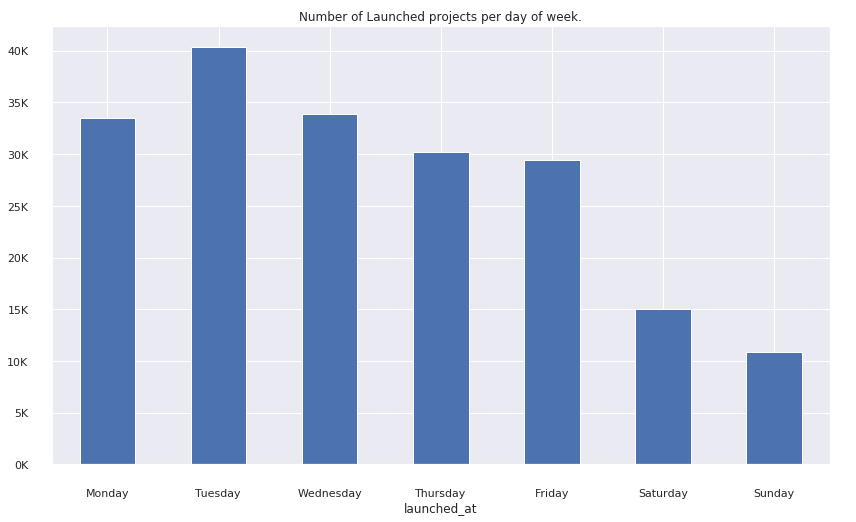

In [103]:
weekday_projs = df_us.groupby(df_us['launched_at'].dt.weekday_name)
filename = os.path.join(imagesdir, 'projects_by_weekdayname.png')
weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot(weekday_projs.size()[weekday_days], filename, y_format='K', kind='bar', 
    title='Number of Launched projects per day of week.')

We can see already that week days have more projects than weekends. Lets study the result per day launched.

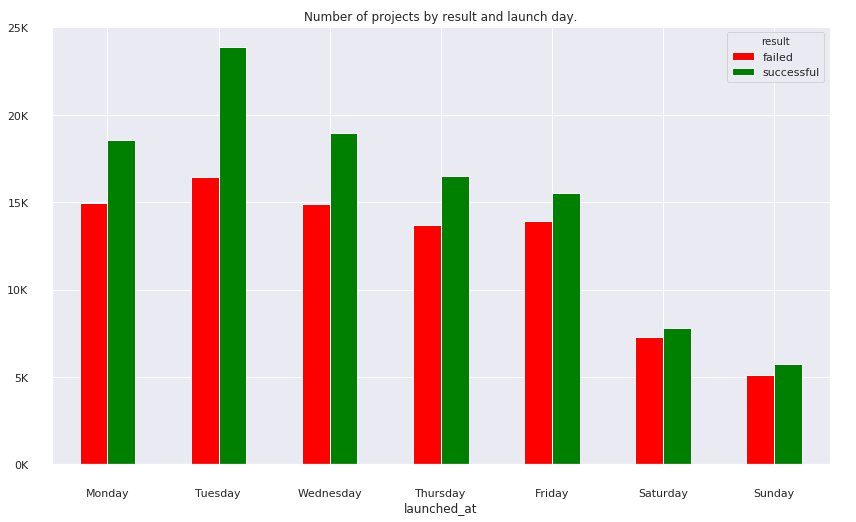

In [104]:
weekday_projs_result = df_us.pivot_table(index=df_us['launched_at'].dt.weekday_name,
                                         columns='result', aggfunc='size')
weekday_projs_result = weekday_projs_result.loc[weekday_days, :]
filename = os.path.join(imagesdir, 'projects_by_weekday_by_result.png')

plot(weekday_projs_result, filename, y_format='K', title="Number of projects by result and launch day.",
    colors=['red', 'green'])

Apparently we do not see great differences between days.

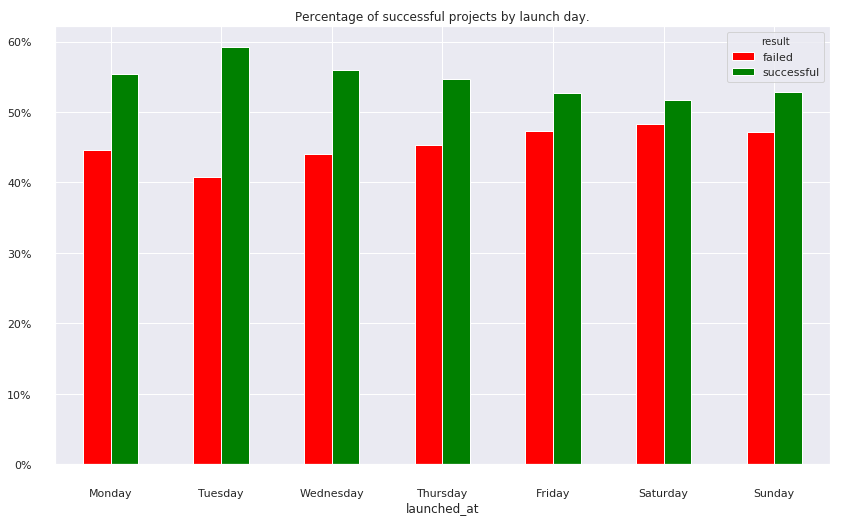

In [105]:
weekday_projs_result_pct = weekday_projs_result.apply(lambda x: x / sum(x), axis=1)
filename = os.path.join(imagesdir, 'projects_by_weekday_by_result_pct.png')

plot(weekday_projs_result_pct, filename, y_format='pct', colors=['red', 'green'],
     title="Percentage of successful projects by launch day.")

##### N.2 Dealine day of week

Lets see the same study for the day a project ends.

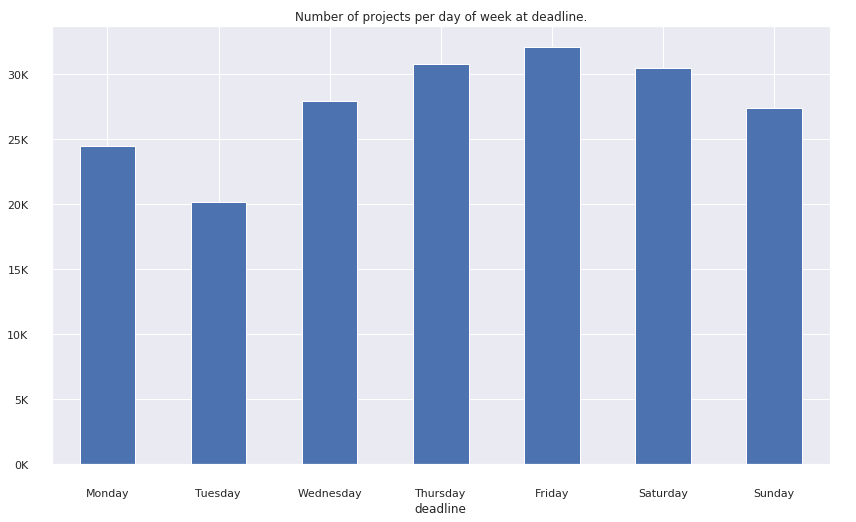

In [106]:
weekday_projs = df_us.groupby(df_us['deadline'].dt.weekday_name)
filename = os.path.join(imagesdir, 'projects_by_weekdayname_deadline.png')

weekday_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plot(weekday_projs.size()[weekday_days], filename, y_format='K', kind='bar', 
    title='Number of projects per day of week at deadline.')

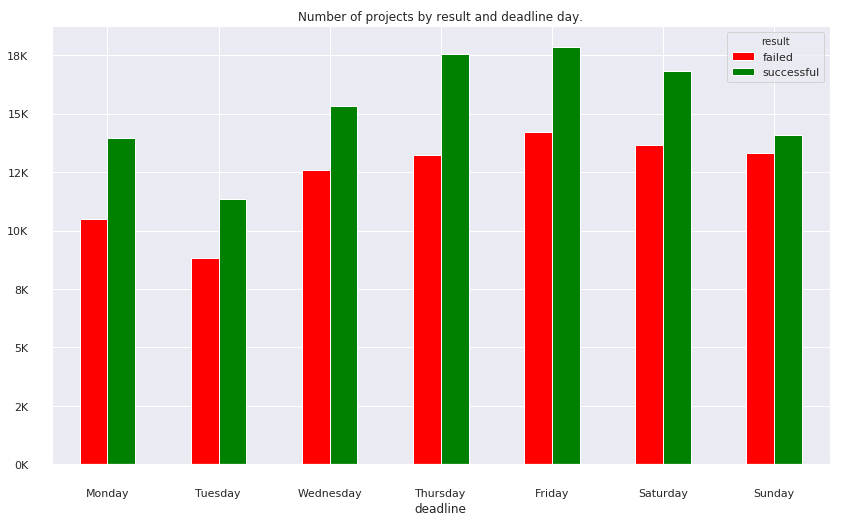

In [107]:
weekday_projs_result = df_us.pivot_table(index=df_us['deadline'].dt.weekday_name,
                                         columns='result', aggfunc='size')
weekday_projs_result = weekday_projs_result.loc[weekday_days, :]
filename = os.path.join(imagesdir, 'projects_by_weekday_by_result_deadline.png')

plot(weekday_projs_result, filename, y_format='K', title="Number of projects by result and deadline day.",
    colors=['red', 'green'])

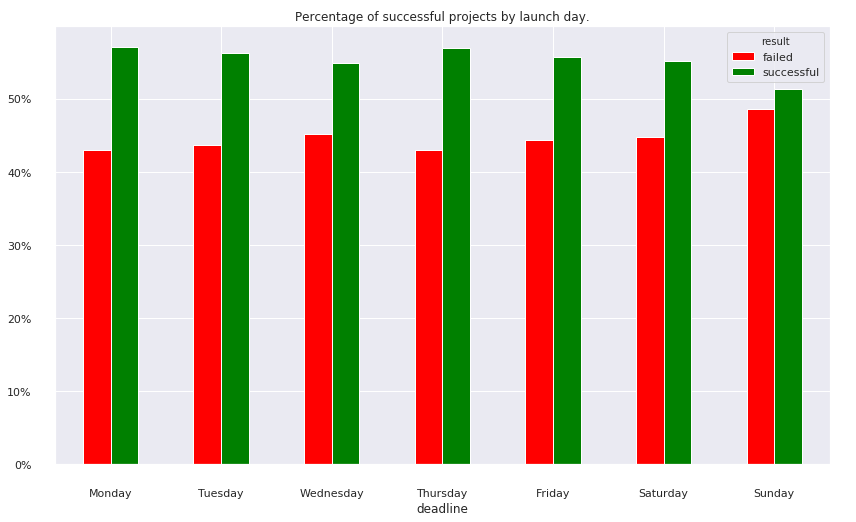

In [108]:
weekday_projs_result_pct = weekday_projs_result.apply(lambda x: x / sum(x), axis=1)
filename = os.path.join(imagesdir, 'projects_by_weekday_by_result_pct.png')

plot(weekday_projs_result_pct, filename, y_format='pct', colors=['red', 'green'],
     title="Percentage of successful projects by launch day.")

We do not see that there are big differences in deadline aspect.

<Figure size 1440x1080 with 0 Axes>

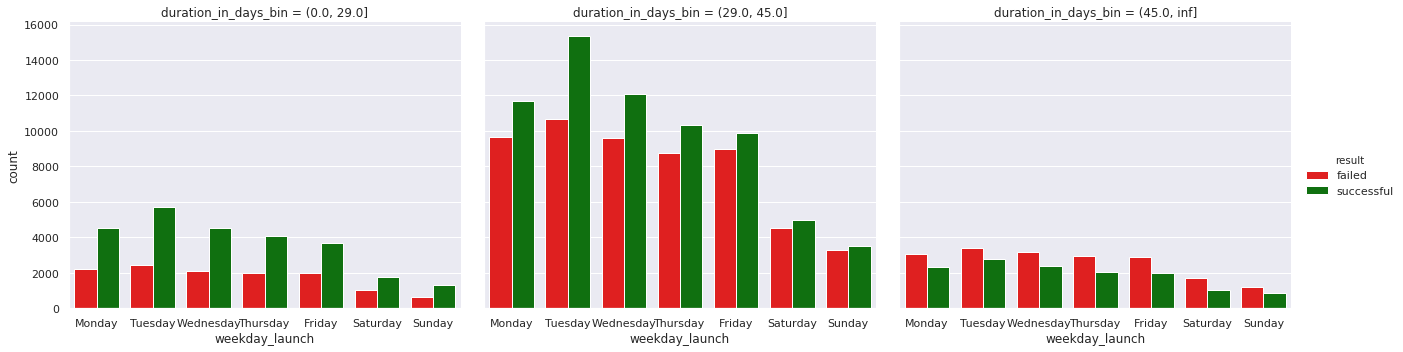

In [109]:
df_us['weekday_launch'] = df_us['launched_at'].dt.weekday_name.astype(
    CategoricalDtype(categories=weekday_days, ordered=False)
)

fig = plt.figure(figsize=(20, 15))

g = sns.catplot(x='weekday_launch', hue='result', col='duration_in_days_bin',
                palette=['red', 'green'], aspect=1.2, kind='count', data=df_us);

##### N.3 Weekend Launched study. 

Lets study differences if weekend or not weekend.

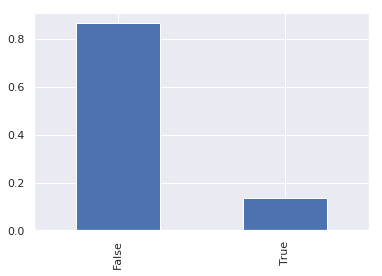

In [110]:
df_us['weekend_launch'] = (df_us['launched_at'].dt.weekday > 4)
df_us['weekend_launch'].value_counts(normalize=True).plot(kind='bar')

In [111]:
df_us.groupby('result').size()

result
failed         86330
successful    106884
dtype: int64

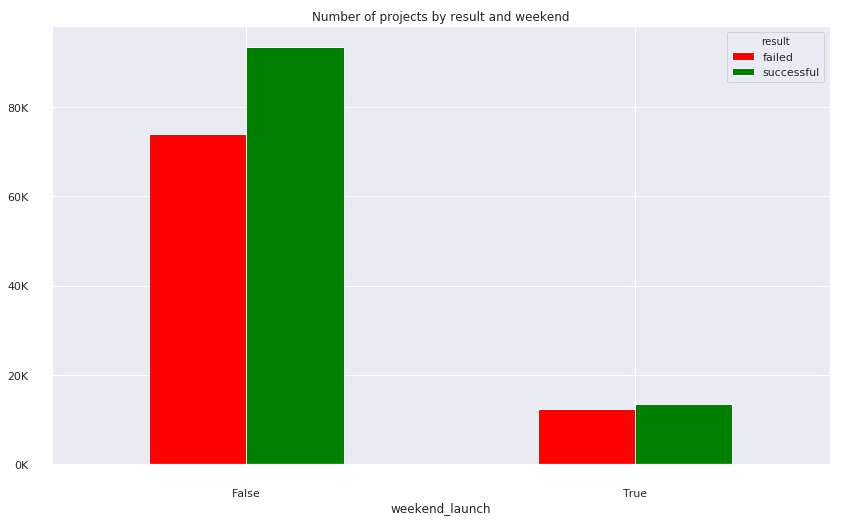

In [112]:
weekend_projs = df_us.pivot_table(index='weekend_launch', columns='result', aggfunc='size')
filename = os.path.join(imagesdir, 'projects_by_weekend_by_result.png')
plot(weekend_projs, filename, y_format='K', colors=['red', 'green'], 
     title='Number of projects by result and weekend')

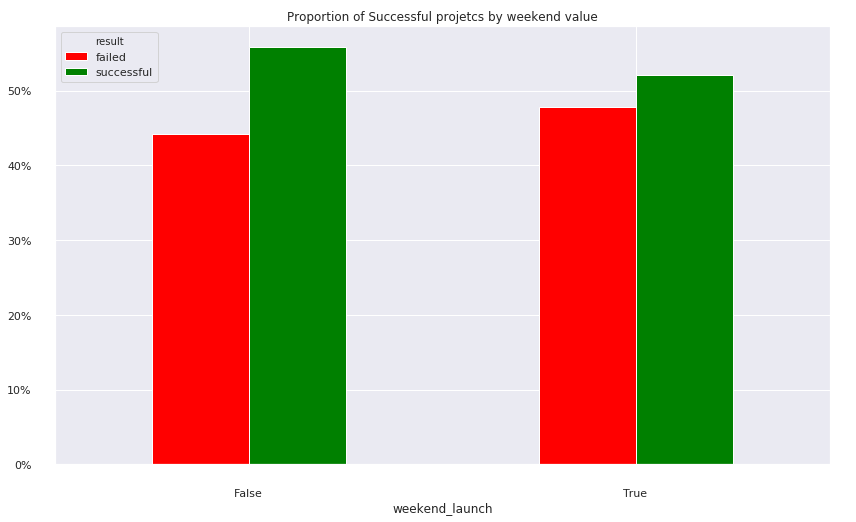

In [113]:
weekend_projs_pct = weekend_projs.apply(lambda x: x/sum(x), axis=1)
filename = os.path.join(imagesdir, 'projects_by_weekend_by_result.png')
plot(weekend_projs_pct, filename, y_format='pct', colors=['red', 'green'], 
     title='Proportion of Successful projetcs by weekend value')

<Figure size 1440x1080 with 0 Axes>

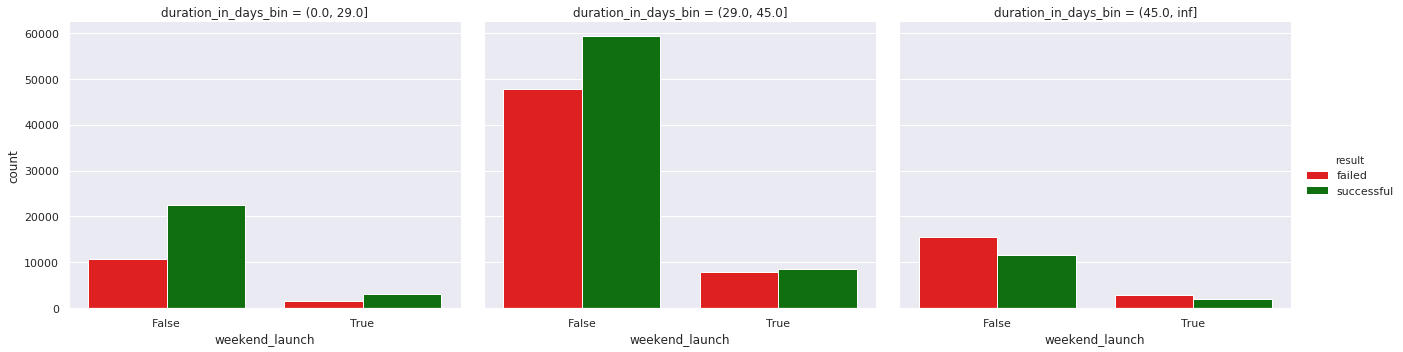

In [114]:
fig = plt.figure(figsize=(20, 15))

g = sns.catplot(x='weekend_launch', hue='result', col='duration_in_days_bin',
                palette=['red', 'green'], aspect=1.2, kind='count', data=df_us);

##### N.4 Month Launched Result

In [115]:
df_us['month_launch'] = df_us['launched_at'].dt.month

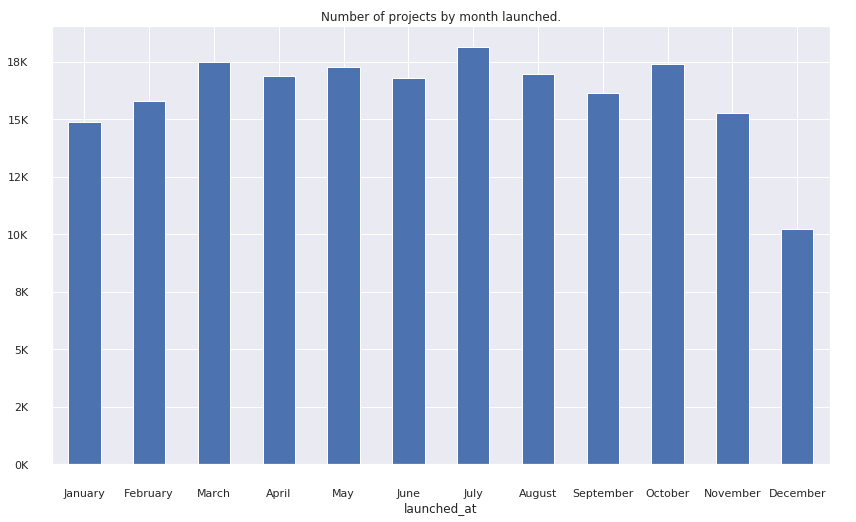

In [116]:
month_projs = df_us.pivot_table(index=df_us['launched_at'].dt.month_name(),
                                columns='result', aggfunc='size')
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
month_projs = month_projs.reindex(months)

filename = os.path.join(imagesdir, 'projects_by_month_by_result.png')

plot(month_projs.apply(lambda x: x.sum(), axis=1), filename, y_format='K',
     title='Number of projects by month launched.')

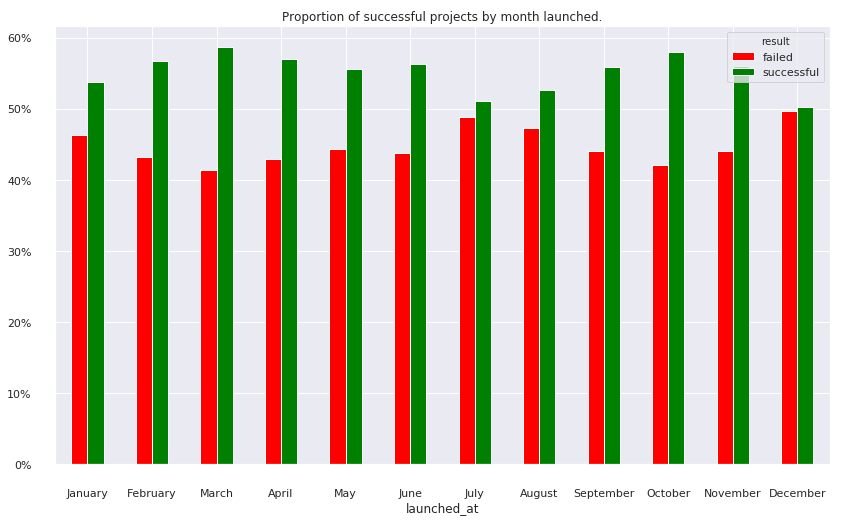

In [117]:
filename = os.path.join(imagesdir, 'projects_by_month_by_result_pct.png')

plot(month_projs.apply(lambda x: x/x.sum(), axis=1), filename, y_format='pct', colors=['red', 'green'],
     title='Proportion of successful projects by month launched.')

#### O. Number of Competitors by Result.

We will compute the number of competitors for each project. The number of competitors will be determined as the number of projects that have the same main category, and have been launched at most 30 days before the project is launched. We will also have a look at the location for computing the number of competitors.

In [118]:
df_us_date_idx = df_us.set_index('launched_at', drop=False).sort_index()

For obtaining the number of competitors first we will group by main category and state so that we have in each group only projetcs with equal main category and launched in the same state. Then we will select within each group all the projetcs launched 30 days before the project and compute the number of projects within those 30 days.

In [119]:
groups = df_us_date_idx.groupby(['main_category', 'state'])
df_us_date_idx['num_competitors'] = groups['result'].transform(lambda x: x.notna().rolling('30D').count())

In [120]:
df_us_date_idx['num_competitors'].describe()

count    193214.000000
mean         15.810283
std          21.022816
min           1.000000
25%           3.000000
50%           8.000000
75%          18.000000
max         149.000000
Name: num_competitors, dtype: float64

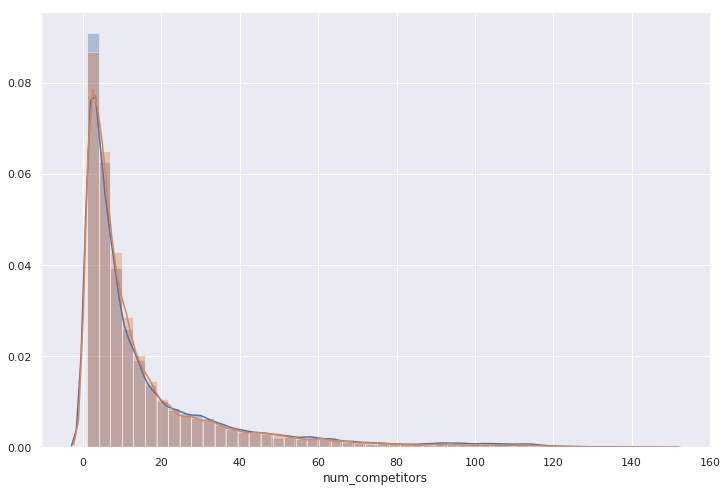

In [121]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

success_projs = df_us_date_idx[df_us_date_idx['result'] == 'successful']
failed_projs = df_us_date_idx[df_us_date_idx['result'] == 'failed']
sns.distplot(success_projs['num_competitors'], kde=True, ax=ax)
sns.distplot(failed_projs['num_competitors'], kde=True, ax=ax)

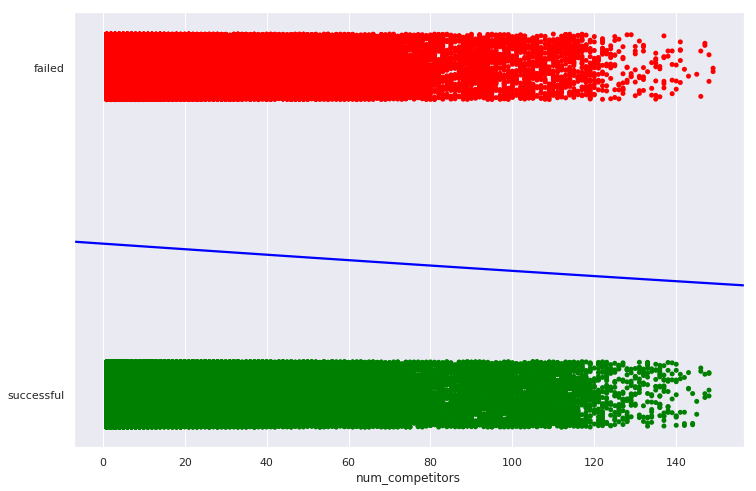

In [122]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df_us_date_idx, 
    x = df_us_date_idx['num_competitors'], 
    y = 'result',
    palette = ['red', 'green'],
    jitter = 0.1, 
    ax = ax
)

sns.regplot(
    x = df_us_date_idx['num_competitors'],
    y = df_us_date_idx.result.cat.codes,
    data = df_us_date_idx,
    ci = None,
    scatter = False,
    logistic = True,
    line_kws = {"color": "blue"},
    ax = ax
)

plt.show()

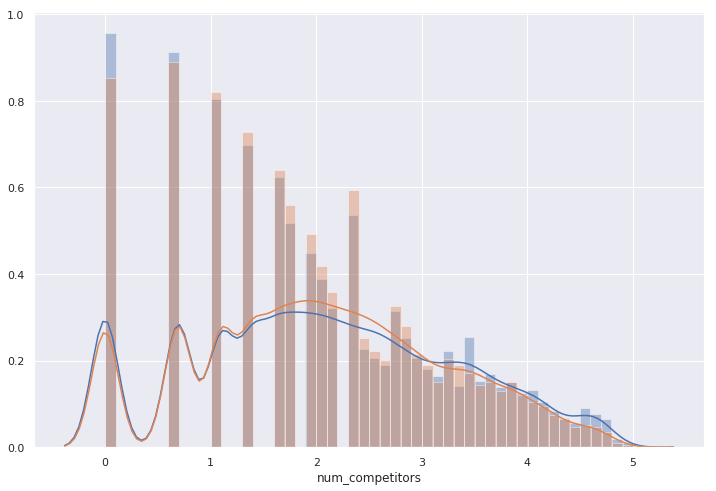

In [123]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

success_projs = df_us_date_idx[df_us_date_idx['result'] == 'successful']
failed_projs = df_us_date_idx[df_us_date_idx['result'] == 'failed']
sns.distplot(np.log(success_projs['num_competitors']), kde=True, ax=ax)
sns.distplot(np.log(failed_projs['num_competitors']), kde=True, ax=ax)

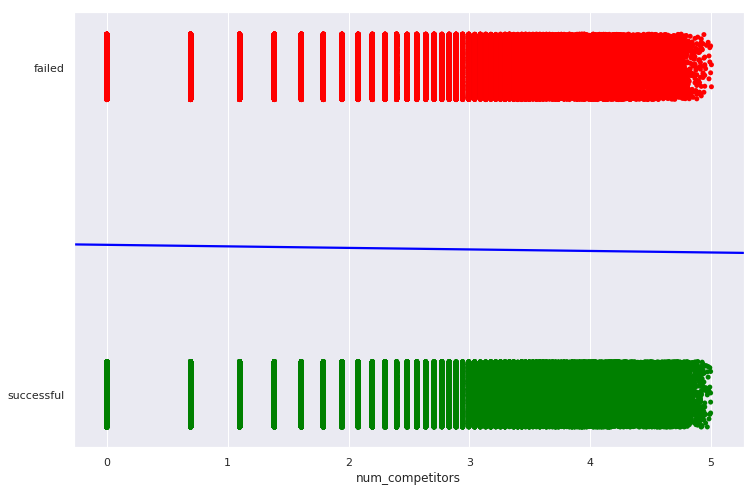

In [124]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df_us_date_idx, 
    x = np.log(df_us_date_idx['num_competitors']), 
    y = 'result',
    palette = ['red', 'green'],
    jitter = 0.1, 
    ax = ax
)

sns.regplot(
    x = np.log(df_us_date_idx['num_competitors']),
    y = df_us_date_idx.result.cat.codes,
    data = df_us_date_idx,
    ci = None,
    scatter = False,
    logistic = True,
    line_kws = {"color": "blue"},
    ax = ax
)

plt.show()

It appears that the number of competitors does not affect the result of the project. so we will bin the competitors in three ranges.

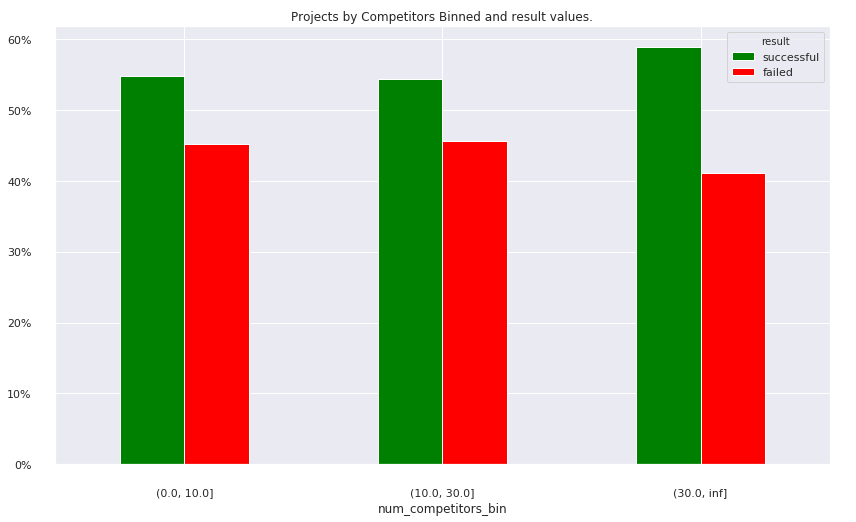

In [125]:
df_us_date_idx['num_competitors_bin'] = pd.cut(df_us_date_idx['num_competitors'], bins =[0, 10, 30, np.inf])

bin_competitors_projs = df_us_date_idx.pivot_table(
        index='num_competitors_bin', columns='result', aggfunc='size'
    )[['successful', 'failed']]
bin_competitors_projs = bin_competitors_projs.apply(lambda x: x / sum(x), axis=1)

filename = os.path.join(imagesdir, 'projects_by_result_by_competitors_bin.png')
plot(bin_competitors_projs, filename, colors=['green', 'red'], y_format='pct', kind='bar', 
    title='Projects by Competitors Binned and result values.')

We do not see great differences between the differente ranges of competitors with respect to the result of the project. Nevertheless we leave the variable just in case the combination with other column result in great insights.

Lets see now the number of competitors that were staff picked.

In [126]:
groups = df_us_date_idx.groupby(['main_category', 'state'])
df_us_date_idx['num_competitors_staffpick'] = groups['staff_pick'].transform(lambda x: x.rolling('30D').sum())

In [127]:
df_us_date_idx['num_competitors_staffpick'].describe()

count    193214.000000
mean          2.127258
std           3.767090
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          31.000000
Name: num_competitors_staffpick, dtype: float64

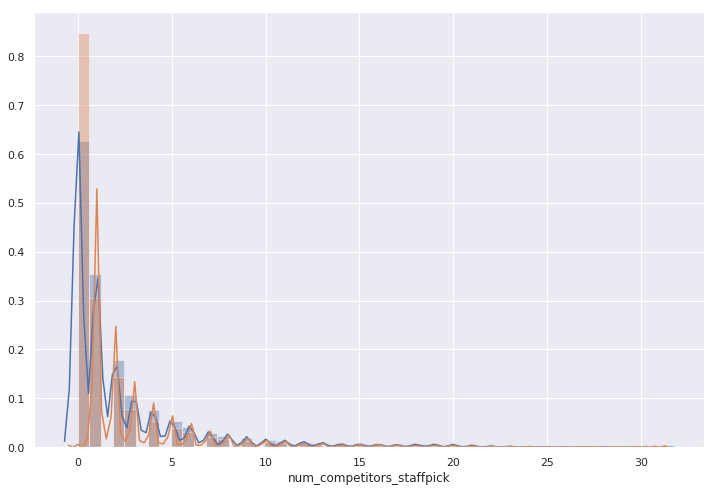

In [128]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

success_projs = df_us_date_idx[df_us_date_idx['result'] == 'successful']
failed_projs = df_us_date_idx[df_us_date_idx['result'] == 'failed']
sns.distplot(success_projs['num_competitors_staffpick'], kde=True, ax=ax)
sns.distplot(failed_projs['num_competitors_staffpick'], kde=True, ax=ax)

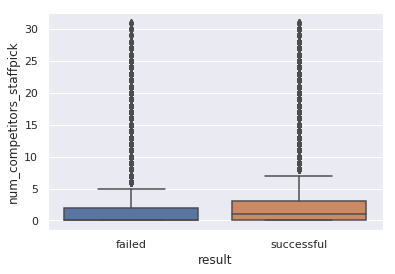

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.boxplot(data=df_us_date_idx, x='result', y='num_competitors_staffpick', ax=ax)

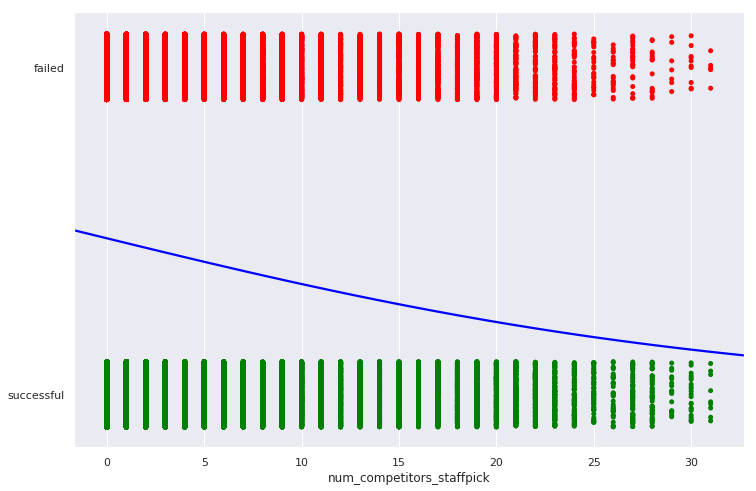

In [130]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

sns.stripplot(
    data = df_us_date_idx, 
    x = df_us_date_idx['num_competitors_staffpick'], 
    y = 'result',
    palette = ['red', 'green'],
    jitter = 0.1, 
    ax = ax
)

sns.regplot(
    x = df_us_date_idx['num_competitors_staffpick'],
    y = df_us_date_idx.result.cat.codes,
    data = df_us_date_idx,
    ci = None,
    scatter = False,
    logistic = True,
    line_kws = {"color": "blue"},
    ax = ax
)

plt.show()

This relation seems not very reasonable. The greater the number of staffpick projects, the higher the probability of success projects. But as we see in the boxplot, anything greater than 5 are outliers.

### 4.4 Correlation between variables

#### A. Set target variable as logical.

First lets select the variables we are going to use and our target variable as logical.

In [131]:
data_ml = df_us_date_idx[['staff_pick', 'result', 'goal_usd', 'pledged_usd', 'main_category', 'state',
                          'ln(goal_usd)', 'goal_usd_bin', 'duration_in_days_bin', 'weekday_launch',
                          'weekend_launch', 'month_launch', 'num_competitors', 'num_competitors_bin',
                          'num_competitors_staffpick']].copy()

In [132]:
data_ml['result'] = data_ml['result'].cat.codes

In [133]:
corr = data_ml.corr()
print(corr)

                           staff_pick    result  goal_usd  pledged_usd  \
staff_pick                   1.000000  0.256353  0.113000     0.127232   
result                       0.256353  1.000000 -0.167652     0.122756   
goal_usd                     0.113000 -0.167652  1.000000     0.167531   
pledged_usd                  0.127232  0.122756  0.167531     1.000000   
ln(goal_usd)                 0.150094 -0.172533  0.785813     0.147648   
weekend_launch              -0.024277 -0.025249 -0.027943    -0.027505   
month_launch                 0.006276 -0.013362  0.018071    -0.000348   
num_competitors              0.026203  0.035290  0.068929     0.008611   
num_competitors_staffpick    0.174203  0.100376  0.082855     0.026603   

                           ln(goal_usd)  weekend_launch  month_launch  \
staff_pick                     0.150094       -0.024277      0.006276   
result                        -0.172533       -0.025249     -0.013362   
goal_usd                       0.785813 

In [134]:
np.triu_indices_from

<function numpy.triu_indices_from(arr, k=0)>

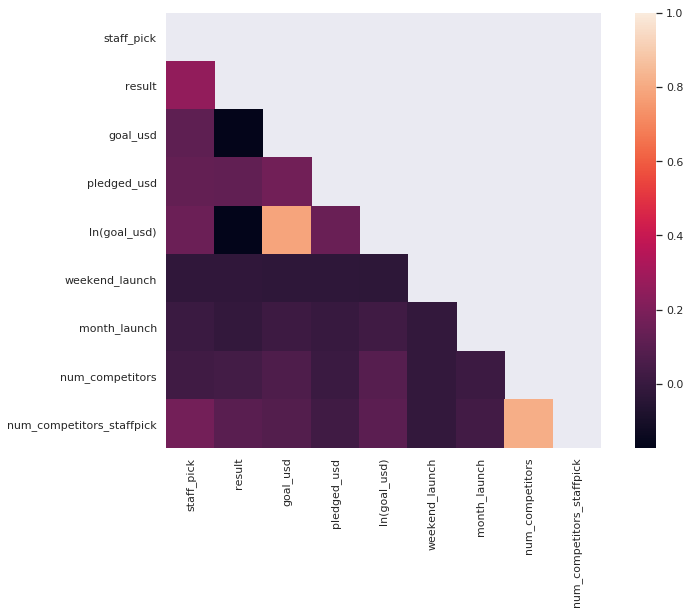

In [135]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmax=1, square=True, ax=ax)
filename = os.path.join(imagesdir,'correlations.png')
fig.savefig(filename, dpi = fig.dpi)

We do not have any special correlations between the variables. Only for variables that are directly related, such as num competitors--num_competitors_staffpick nad got ln(goal_usd)--goal_usd. As we will only use one of these for the model there is no problem.

## 5. Save Data for posterior ML analysis

In [136]:
def store_dataframe(dataframe, filename):
    """
    Store the dataframe using pickle.
    
    Params:
        dataframe...pandas dataframe to store.
        filename....Path to the file to store the datafram in.
    
    Returns:
        Nothing.
    """
    pickle.dump(dataframe, open(filename, 'wb'))

In [137]:
filename = os.path.join(datadir, 'data_cleaned.pkl')
store_dataframe(data_ml, filename)